In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from scipy.stats.stats import pearsonr
from sklearn.ensemble import (ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor, 
                              GradientBoostingRegressor)
from mpl_toolkits.mplot3d import Axes3D
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout

# References:

[Changing tile size on hist](https://stackoverflow.com/questions/46188580/pandas-dataframe-hist-change-title-size-on-subplot/46189639#46189639)

Statistics in a Nutshell by Sarah Boslaugh

[Correlation Heatmap SNS](https://stackoverflow.com/questions/39409866/correlation-heatmap)

[Column Transformer](https://stackoverflow.com/questions/54345667/onehotencoder-categorical-features-depreciated-how-to-transform-specific-column)

[Chris Schon](https://github.com/chrisgschon)

[DengAI Benchmark](http://drivendata.co/blog/dengue-benchmark/)

[Object to Datetime](https://stackoverflow.com/questions/38333954/converting-object-to-datetime-format-in-python)

[Rearanging pandas columns](https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns)

[Drop Rows/Columns on a Dataframe](https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/)

[Seaborn Plotting](https://seaborn.pydata.org/index.html)

[Custom X ticks for a SNS Plot](https://stackoverflow.com/questions/43727278/how-to-set-readable-xticks-in-seaborns-facetgrid)

[Fix heatmap Plot](https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot)

[Poisson Regression Model](https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958)

[Negative Binomial Regression Model](https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4)

[Class for testing multiple ML models](https://github.com/davidsbatista/machine-learning-notebooks/blob/master/hyperparameter-across-models.ipynb)

[PCA](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)

In [2]:
features_test = pd.read_csv('dengue_features_test.csv')
features_train = pd.read_csv('dengue_features_train.csv')
labels_train = pd.read_csv('dengue_labels_train.csv')

In [3]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
city                                     416 non-null object
year                                     416 non-null int64
weekofyear                               416 non-null int64
week_start_date                          416 non-null object
ndvi_ne                                  373 non-null float64
ndvi_nw                                  405 non-null float64
ndvi_se                                  415 non-null float64
ndvi_sw                                  415 non-null float64
precipitation_amt_mm                     414 non-null float64
reanalysis_air_temp_k                    414 non-null float64
reanalysis_avg_temp_k                    414 non-null float64
reanalysis_dew_point_temp_k              414 non-null float64
reanalysis_max_air_temp_k                414 non-null float64
reanalysis_min_air_temp_k                414 non-null float64
reanalysis_precip_amt_kg_per_m2  

In [4]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [5]:
labels_train.describe()

year   weekofyear  total_cases
count  1456.000000  1456.000000  1456.000000
mean   2001.031593    26.503434    24.675137
std       5.408314    15.019437    43.596000
min    1990.000000     1.000000     0.000000
25%    1997.000000    13.750000     5.000000
50%    2002.000000    26.500000    12.000000
75%    2005.000000    39.250000    28.000000
max    2010.000000    53.000000   461.000000

In [6]:
labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [7]:
#Contains all of the train related data (with their total cases)
train_concat = pd.concat([features_train, labels_train['total_cases']], sort=False, axis=1)

train_concat_copy = train_concat.copy()
#Filling with nans the coppied one
train_concat_copy.fillna(method='ffill', inplace=True)

train_concat_copy['set_type']='train'

features_test_copy = features_test.copy()

features_test_copy['set_type'] = 'test'

#putting all the data inside of a single dataframe

all_data = train_concat_copy.append(features_test_copy, sort=False)

all_data['week_start_date'] = pd.to_datetime(all_data['week_start_date'])

all_data['city']=all_data['city'].astype('category')

In [8]:
train_concat.head()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   
3  0.235886                 15.36             298.987143  ...   
4  0.247340                  7.52             299.518571  ...   

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                             73.365714                         12.42   
1                             77.368571                         22.82   
2                             82.052857                         34.54   
3                             80.337143                         15.36   
4                             80.460000                          7.52   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
0                              14.012857           2.628571   
1                              15.372857           2.371429   
2                              16.848571           2.300000   
3                              16.672857           2.428571   
4                              17.210000           3.014286   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           25.442857                 6.900000                29.4   
1           26.714286                 6.371429                31.7   
2           26.714286                 6.485714                32.2   
3           27.471429                 6.771429                33.3   
4           28.942857                 9.371429                35.0   

   station_min_temp_c  station_precip_mm  total_cases  
0                20.0               16.0            4  
1                22.2                8.6            5  
2                22.8               41.4            4  
3                23.3                4.0            3  
4                23.9                5.8            6  

[5 rows x 25 columns]

In [9]:
all_data.head()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   
3  0.235886                 15.36             298.987143  ...   
4  0.247340                  7.52             299.518571  ...   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                              14.012857   
1                         22.82                              15.372857   
2                         34.54                              16.848571   
3                         15.36                              16.672857   
4                          7.52                              17.210000   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           2.628571           25.442857                 6.900000   
1           2.371429           26.714286                 6.371429   
2           2.300000           26.714286                 6.485714   
3           2.428571           27.471429                 6.771429   
4           3.014286           28.942857                 9.371429   

   station_max_temp_c  station_min_temp_c  station_precip_mm  total_cases  \
0                29.4                20.0               16.0          4.0   
1                31.7                22.2                8.6          5.0   
2                32.2                22.8               41.4          4.0   
3                33.3                23.3                4.0          3.0   
4                35.0                23.9                5.8          6.0   

   set_type  
0     train  
1     train  
2     train  
3     train  
4     train  

[5 rows x 26 columns]

In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1872 entries, 0 to 415
Data columns (total 26 columns):
city                                     1872 non-null category
year                                     1872 non-null int64
weekofyear                               1872 non-null int64
week_start_date                          1872 non-null datetime64[ns]
ndvi_ne                                  1829 non-null float64
ndvi_nw                                  1861 non-null float64
ndvi_se                                  1871 non-null float64
ndvi_sw                                  1871 non-null float64
precipitation_amt_mm                     1870 non-null float64
reanalysis_air_temp_k                    1870 non-null float64
reanalysis_avg_temp_k                    1870 non-null float64
reanalysis_dew_point_temp_k              1870 non-null float64
reanalysis_max_air_temp_k                1870 non-null float64
reanalysis_min_air_temp_k                1870 non-null float64
reanalys

In [11]:
all_data.select_dtypes(include=[np.number]).drop(['year', 'weekofyear', 'total_cases'], axis = 1).columns.tolist()

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

In [12]:
numeric_cols = all_data.select_dtypes(include=[np.number]).drop(['year', 'weekofyear', 'total_cases'], axis = 1).columns.tolist()

In [13]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1872 entries, 0 to 415
Data columns (total 26 columns):
city                                     1872 non-null category
year                                     1872 non-null int64
weekofyear                               1872 non-null int64
week_start_date                          1872 non-null datetime64[ns]
ndvi_ne                                  1829 non-null float64
ndvi_nw                                  1861 non-null float64
ndvi_se                                  1871 non-null float64
ndvi_sw                                  1871 non-null float64
precipitation_amt_mm                     1870 non-null float64
reanalysis_air_temp_k                    1870 non-null float64
reanalysis_avg_temp_k                    1870 non-null float64
reanalysis_dew_point_temp_k              1870 non-null float64
reanalysis_max_air_temp_k                1870 non-null float64
reanalysis_min_air_temp_k                1870 non-null float64
reanalys

# Analysis/Preprocessing
For now, all I have done is verify what data I have, what is missing, what should be converted to datetime etc.

From my observations there is a fraction of the data that was missing so I simply forward filled it. I was gonna impute by the mean values, but it ended up giving me bad results in the machine learning process later on so I ignored it.

The week_start_date column was an object column, but I thought it would be more usefull as a DateTime column, hence I converted it. Then, the city column was a string, but I turned it into a category column, for it could be easier to manage later on.

Another thing I did was to concatenate all the training data into one DF since it comes separate into two. Then I also made a DF with contains the whole training and testing datasets. Before doing so, I created a new column on each called set_type so I could easily identify them as either test or train.

Finally, I initially had a StandardScaler for the data, but I then realized I was using it incorrectly since it could make the data in the machine learning process not work as well. StandardScaler should only be used DURING the machine learning process on the training and test set. (or so I've read)

# Correlations from San Juan only (train data)

In [14]:
sj_train_data = all_data[(all_data['city']=='sj') & (all_data['set_type'] == 'train')]

sjcorr = sj_train_data[sj_train_data.columns.tolist()[-2:] + sj_train_data.columns.tolist()[:-2]].corr()

In [15]:
sjcorr_sorted = sjcorr[['total_cases']].sort_values(by='total_cases', ascending=False)
sjcorr_sorted.drop('total_cases', axis=0)

total_cases
weekofyear                                0.287134
reanalysis_specific_humidity_g_per_kg     0.205338
reanalysis_dew_point_temp_k               0.201086
station_avg_temp_c                        0.194126
reanalysis_max_air_temp_k                 0.192635
station_max_temp_c                        0.187544
reanalysis_min_air_temp_k                 0.185525
reanalysis_air_temp_k                     0.179402
station_min_temp_c                        0.174285
reanalysis_avg_temp_k                     0.172569
reanalysis_relative_humidity_percent      0.142317
reanalysis_precip_amt_kg_per_m2           0.106591
ndvi_nw                                   0.059208
precipitation_amt_mm                      0.056942
reanalysis_sat_precip_amt_mm              0.056942
station_precip_mm                         0.050835
ndvi_sw                                   0.041055
station_diur_temp_rng_c                   0.034801
ndvi_ne                                   0.004144
reanalysis_tdtr_k                        -0.067920
ndvi_se                                  -0.120024
year                                     -0.212690

Text(0.5, 1.0, 'Co-relation for SJ Data')

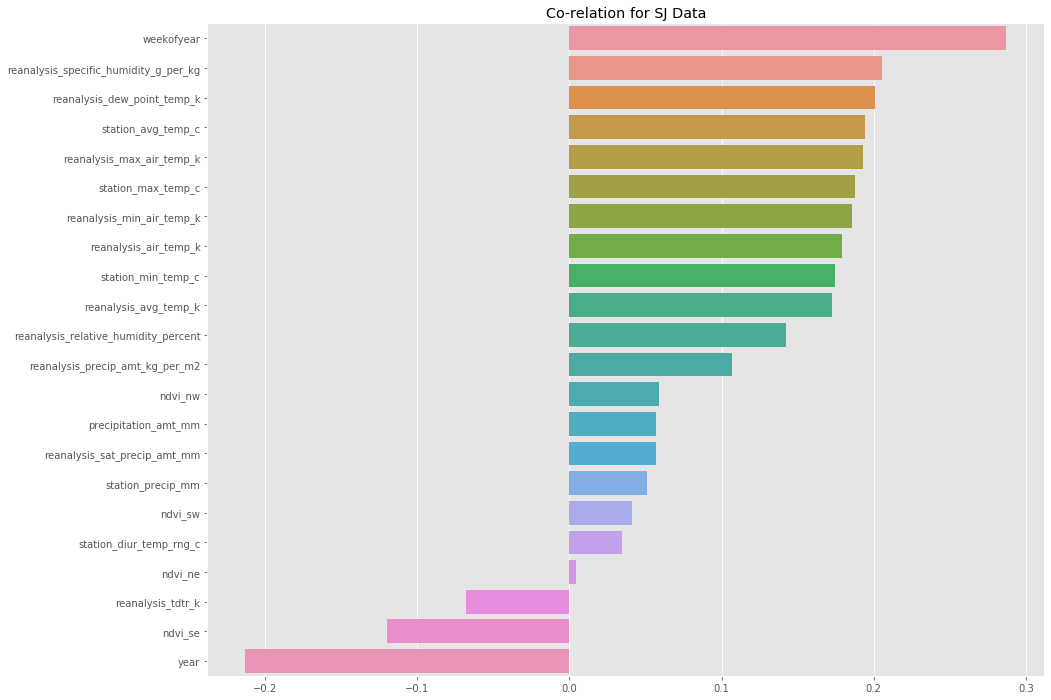

In [16]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,12))

sns.barplot(x=sjcorr_sorted['total_cases'].drop('total_cases', axis=0).values, y=sjcorr_sorted.drop('total_cases', axis=0).index.values, ax=ax)

plt.title('Co-relation for SJ Data')

(23.0, 0.0)

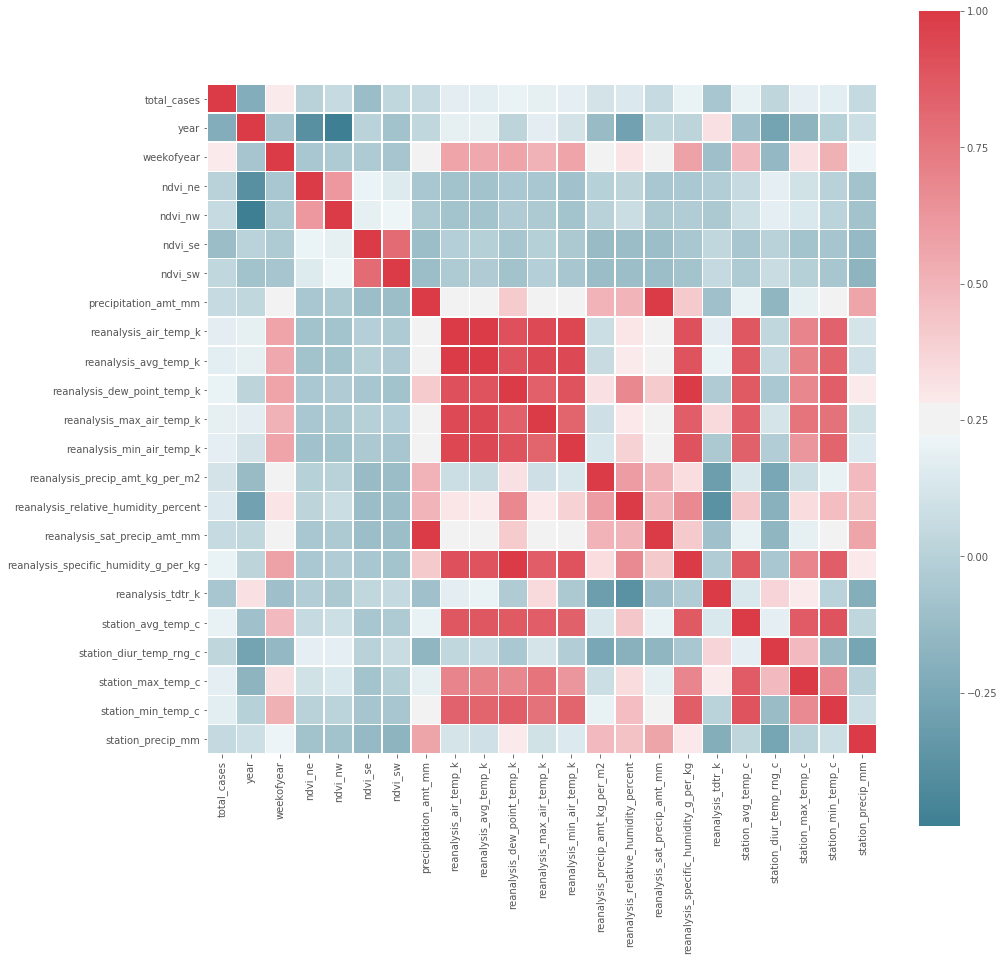

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
g = sns.heatmap(sjcorr, ax=ax,cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, linewidths=.5)
bottom, top = g.get_ylim()

g.set_ylim(bottom+0.5,top-0.5) #this is a fix for the uncentered heatmap

Pearson Corelation between SJ total cases and all other data

In [18]:
for i in numeric_cols:
    print(i,pearsonr(sj_train_data[i], sj_train_data.total_cases))

ndvi_ne (0.004144238286389072, 0.8992408281876709)
ndvi_nw (0.05920785705233967, 0.070205877618032)
ndvi_se (-0.12002352728990016, 0.0002328510344404936)
ndvi_sw (0.041054890851796644, 0.2095191332528958)
precipitation_amt_mm (0.056942494270618725, 0.08165023239092593)
reanalysis_air_temp_k (0.17940178147754587, 3.272436408616772e-08)
reanalysis_avg_temp_k (0.17256852265608752, 1.0817291942276641e-07)
reanalysis_dew_point_temp_k (0.20108565857597116, 5.389288596859638e-10)
reanalysis_max_air_temp_k (0.19263512227237037, 2.826702865570849e-09)
reanalysis_min_air_temp_k (0.18552500897958257, 1.0772150598862751e-08)
reanalysis_precip_amt_kg_per_m2 (0.10659074348147515, 0.0010907806827510369)
reanalysis_relative_humidity_percent (0.14231697050664804, 1.2395774561224598e-05)
reanalysis_sat_precip_amt_mm (0.056942494270618725, 0.08165023239092593)
reanalysis_specific_humidity_g_per_kg (0.20533763924177664, 2.2765640442704164e-10)
reanalysis_tdtr_k (-0.06791954731626959, 0.03774978572752387)


# Correlations from Iquitos only (train data)

In [19]:
iq_train_data = all_data[(all_data['city']=='iq')& (all_data['set_type'] == 'train')]

iqcorr = iq_train_data[iq_train_data.columns.tolist()[-2:] + iq_train_data.columns.tolist()[:-2]].corr()

In [20]:
iqcorr_sorted=iqcorr[['total_cases']].sort_values(by='total_cases', ascending=False)
iqcorr_sorted.drop('total_cases', axis=0)

total_cases
reanalysis_specific_humidity_g_per_kg     0.234918
reanalysis_dew_point_temp_k               0.228864
reanalysis_min_air_temp_k                 0.210854
station_min_temp_c                        0.202844
year                                      0.179451
reanalysis_relative_humidity_percent      0.128548
station_avg_temp_c                        0.114431
reanalysis_precip_amt_kg_per_m2           0.100686
reanalysis_air_temp_k                     0.096666
reanalysis_sat_precip_amt_mm              0.089410
precipitation_amt_mm                      0.089410
reanalysis_avg_temp_k                     0.080056
station_max_temp_c                        0.079937
station_precip_mm                         0.045283
ndvi_sw                                   0.031369
ndvi_ne                                   0.019740
ndvi_nw                                  -0.010520
weekofyear                               -0.011850
station_diur_temp_rng_c                  -0.021254
ndvi_se                                  -0.041153
reanalysis_max_air_temp_k                -0.053157
reanalysis_tdtr_k                        -0.130535

Text(0.5, 1.0, 'Corelation for IQ Data')

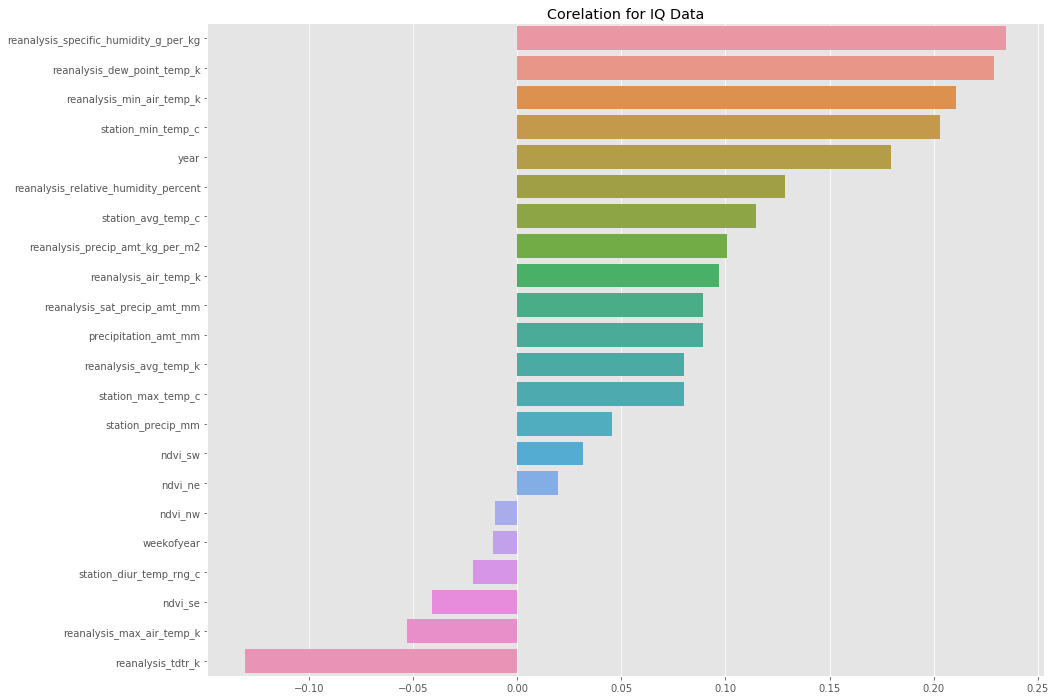

In [21]:
fig, ax = plt.subplots(figsize=(15,12))

sns.barplot(x=iqcorr_sorted['total_cases'].drop('total_cases', axis=0).values, y=iqcorr_sorted.drop('total_cases', axis=0).index.values, ax=ax)

plt.title('Corelation for IQ Data')

(23.0, 0.0)

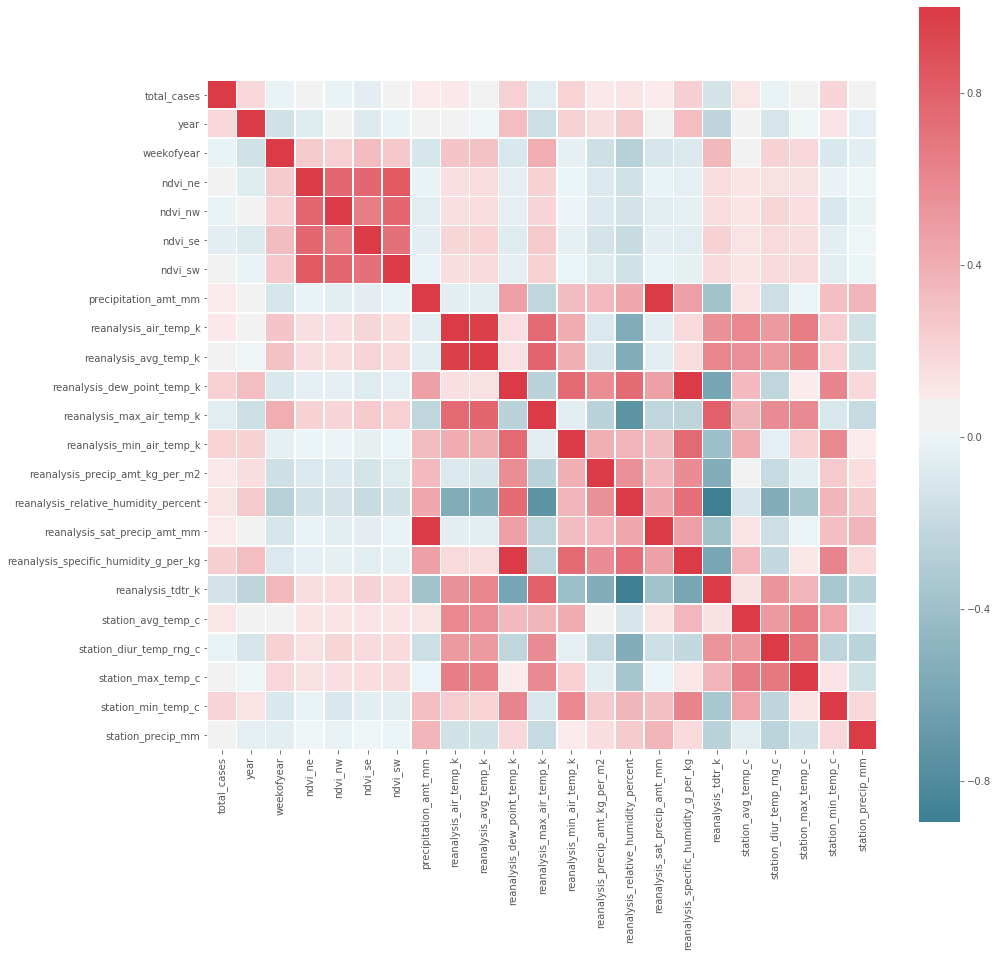

In [22]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,15))
g = sns.heatmap(iqcorr, ax=ax,cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, linewidths=.5)
bottom, top = g.get_ylim()

g.set_ylim(bottom+0.5,top-0.5) #this is a fix for the uncentered heatmap

Pearson correlation between IQ total cases and all other data

In [23]:
for i in numeric_cols:
    print(i,pearsonr(iq_train_data[i], iq_train_data.total_cases))

ndvi_ne (0.019739662629656762, 0.6533637953252827)
ndvi_nw (-0.010519633335991308, 0.8108621988705742)
ndvi_se (-0.04115344686762155, 0.34897391634610164)
ndvi_sw (0.03136931867100151, 0.4753602903215859)
precipitation_amt_mm (0.08941045113267557, 0.041545055764576164)
reanalysis_air_temp_k (0.09666581487976966, 0.02751175334428183)
reanalysis_avg_temp_k (0.08005578481849038, 0.06813875041329862)
reanalysis_dew_point_temp_k (0.22886350764368762, 1.3165782407808998e-07)
reanalysis_max_air_temp_k (-0.05315725507387228, 0.2262364913603058)
reanalysis_min_air_temp_k (0.2108540364563748, 1.2266269792262164e-06)
reanalysis_precip_amt_kg_per_m2 (0.10068588610348451, 0.02165849660735897)
reanalysis_relative_humidity_percent (0.12854756120508243, 0.003319677294446616)
reanalysis_sat_precip_amt_mm (0.08941045113267557, 0.041545055764576164)
reanalysis_specific_humidity_g_per_kg (0.23491815686483175, 5.95661972990732e-08)
reanalysis_tdtr_k (-0.1305353838621246, 0.00286118392538795)
station_avg_te

# Corelation Conclusion

Here I am trying to see which data co-relates more with the total_cases column, thus helping me make a better decision on which of the columns I should focus on when creating the ML model. So far, there arent many strong corelations, but the ones that do have the highest corelations are:
\
\
\
**San Juan:**

reanalysis_specific_humidity_g_per_kg 	0.205338

reanalysis_dew_point_temp_k 	0.201086

station_avg_temp_c 	0.194126

reanalysis_max_air_temp_k 	0.192635
\
\
\
**Iquitos:**

reanalysis_specific_humidity_g_per_kg 	0.234918

reanalysis_dew_point_temp_k 	0.228864

reanalysis_min_air_temp_k 	0.210854

station_min_temp_c 	0.202844
\
\
\
Humidity being the highest corelation means that dengue dissease seems to spread more at rainy seasons. This makes sense since mosquitos tend to reproduce on stuck water, and they are one of the biggest spreaders of the dengue dissease.

# Regression Plot for both cities over all train data

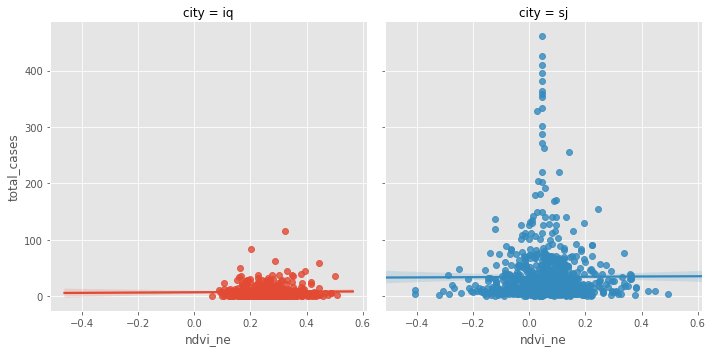

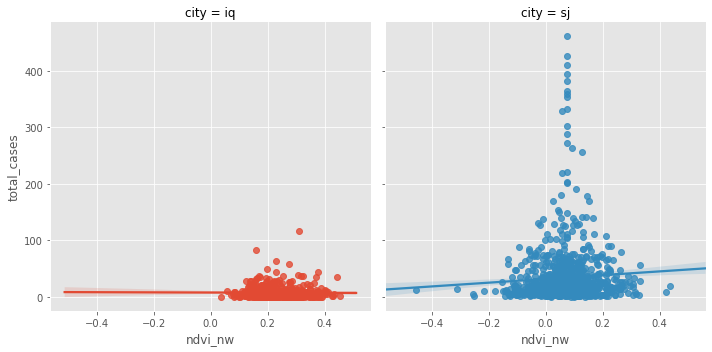

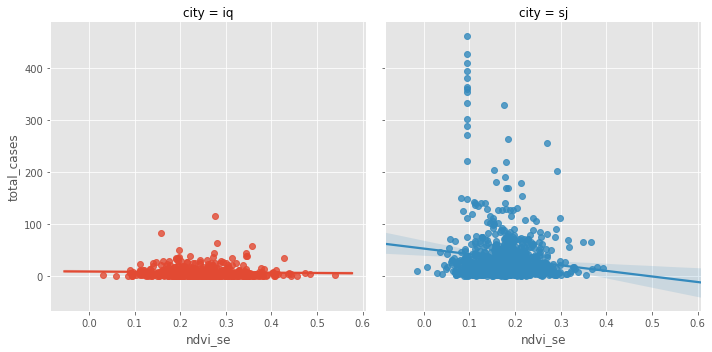

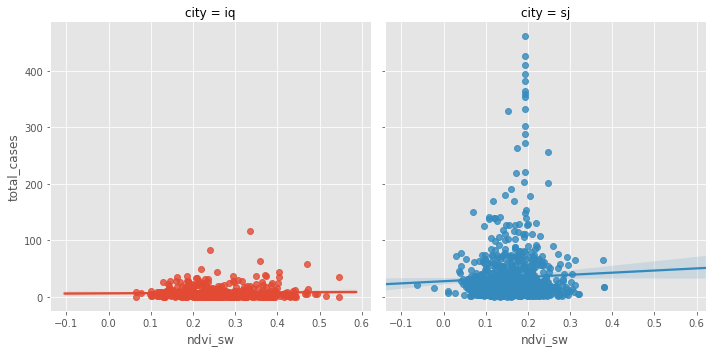

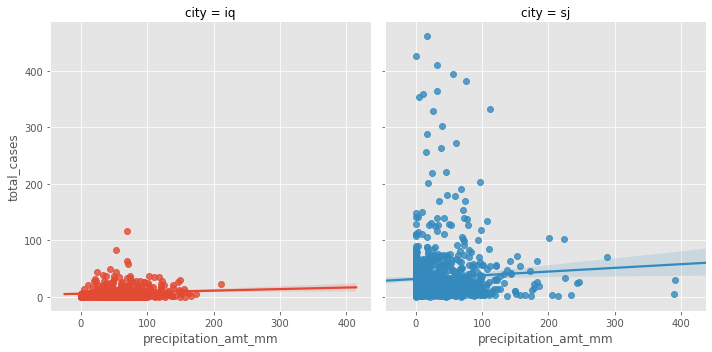

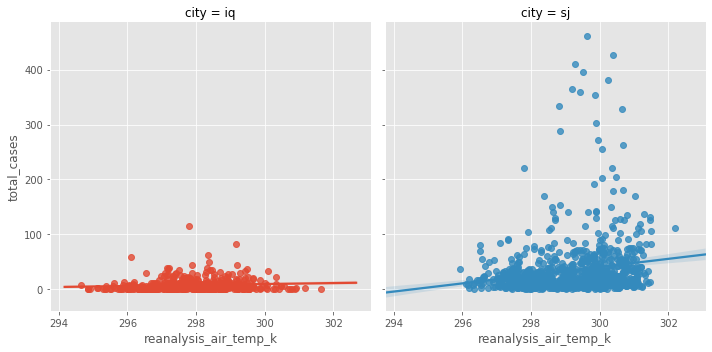

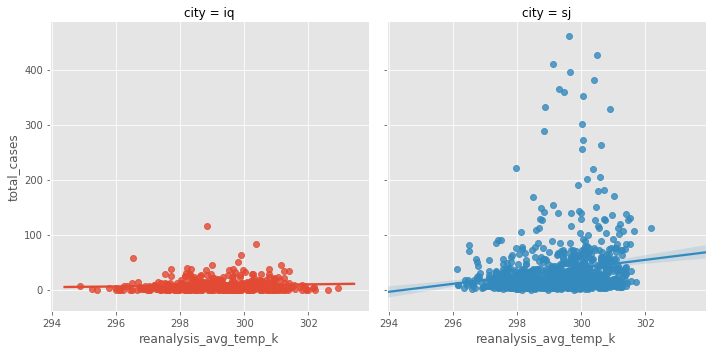

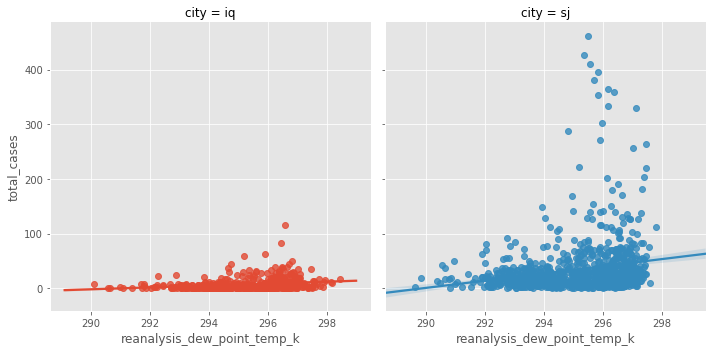

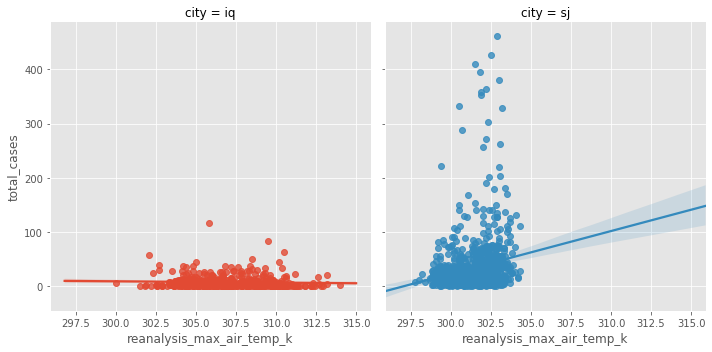

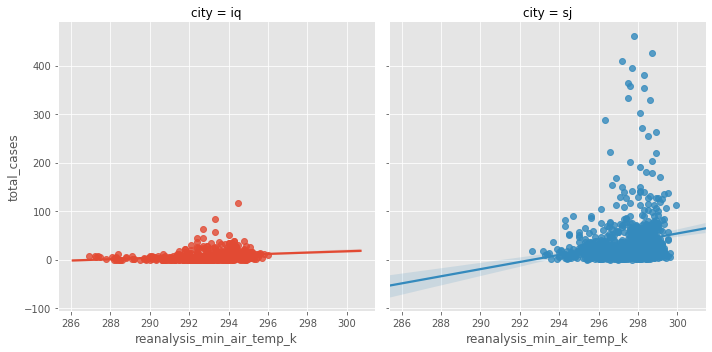

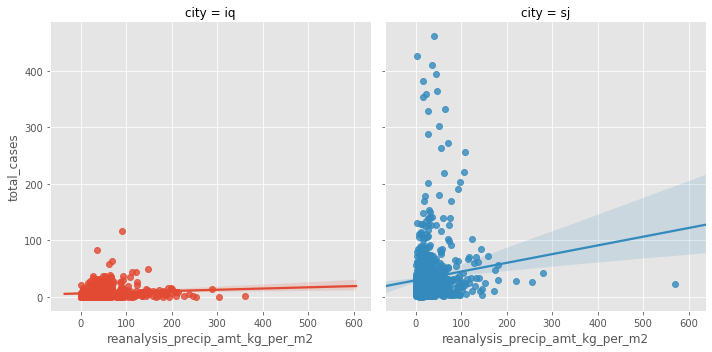

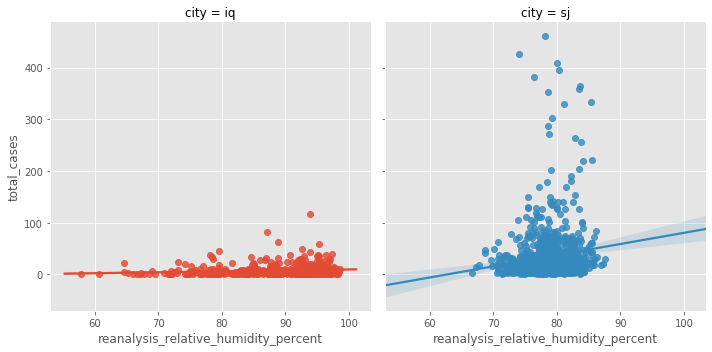

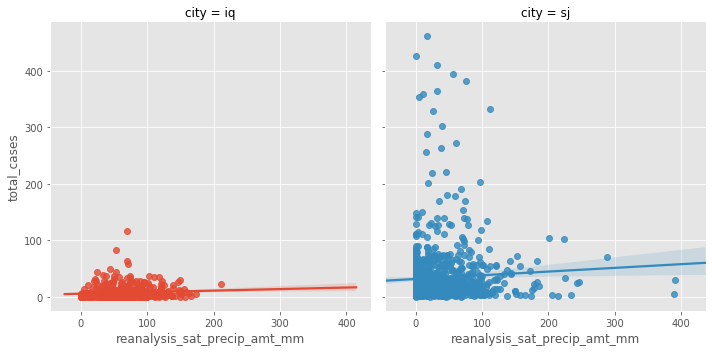

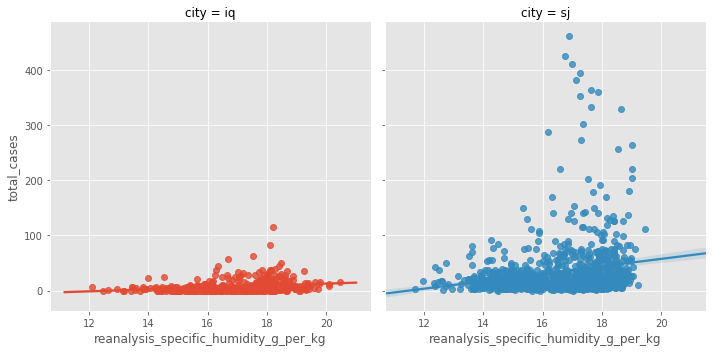

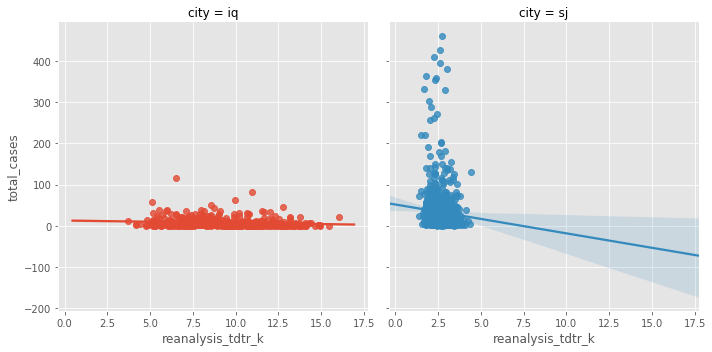

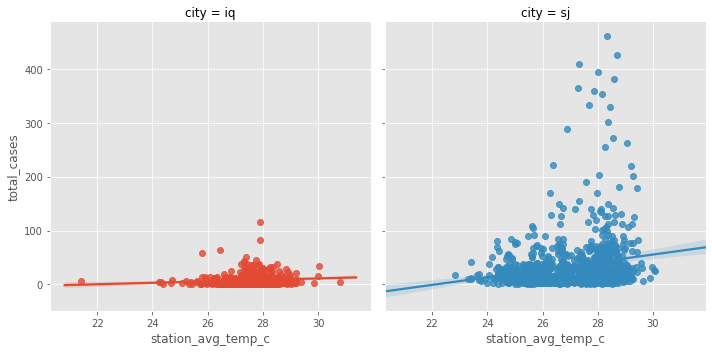

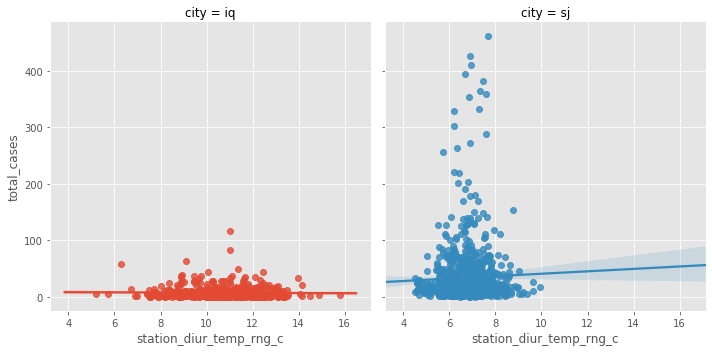

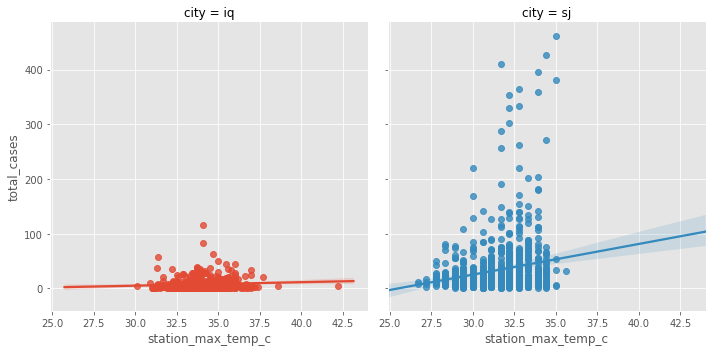

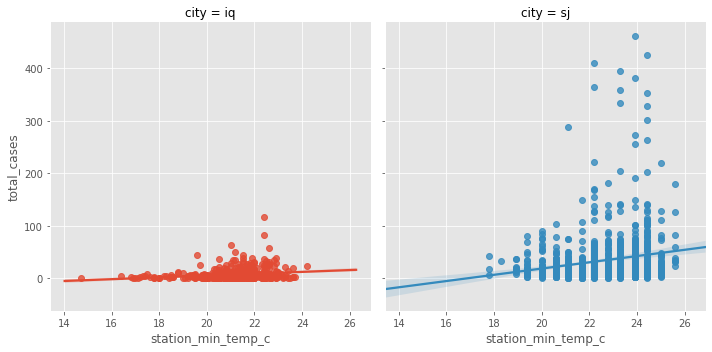

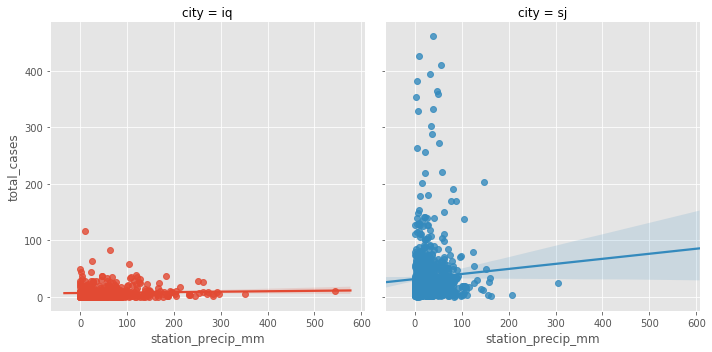

In [24]:
all_train_data = all_data[all_data['set_type'] == 'train']

#Grabbing only the numerical columns to iterate
colums_to_iter = all_train_data.columns[4:-2].values

#graphing a regression for all the data in both cities
for col in colums_to_iter:
    sns.lmplot(col,'total_cases',hue='city',col='city',
               data = all_train_data)    
    plt.show()

# Regression Analysis and Conclusion

Here one can see that San Juan has a higher corelation with the dataset (partly because it has more data to use).
\
\
Looking at reanalysis_specific_humidity_g_per_kg (which, as stated before, was the one with the highest corelation on both SJ and IQ) we can see that for SJ the data has more spread and has more significance than for IQ. This same pattern goes for reanalysis_dew_point_temp_k.
\
\
So far with what I have, it is easy to say that a LinearRegression model won't be as good as I'd wish. This because, as seen before this, corelations arent strong enough for a LinearRegression to be as effective. Furthermore, if we do a LinearRegression, it might only be effective on the SJ data, but the IQ data might not give us any good results.

# Distribution of Data

### For training data of both cities

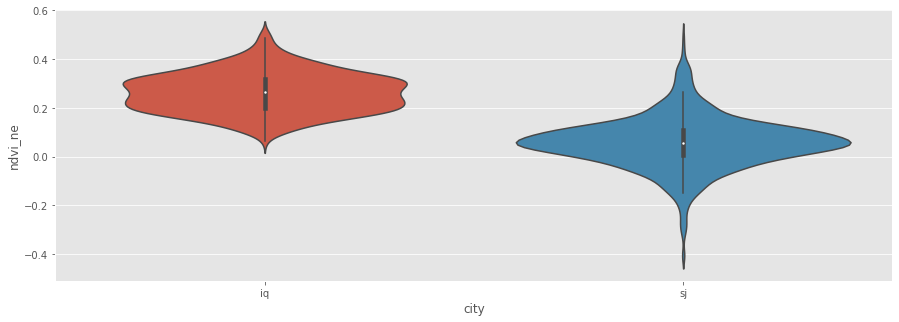

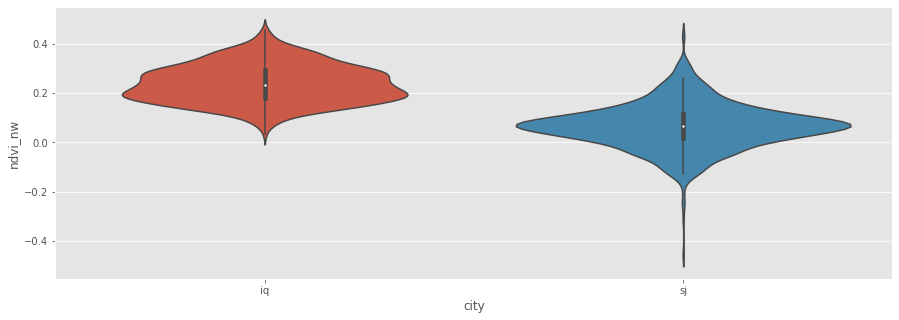

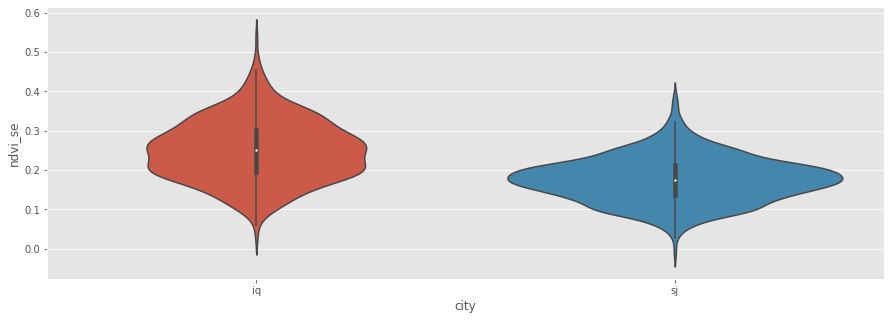

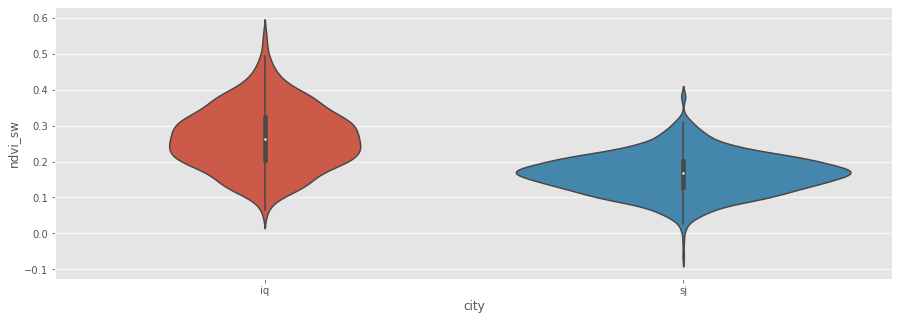

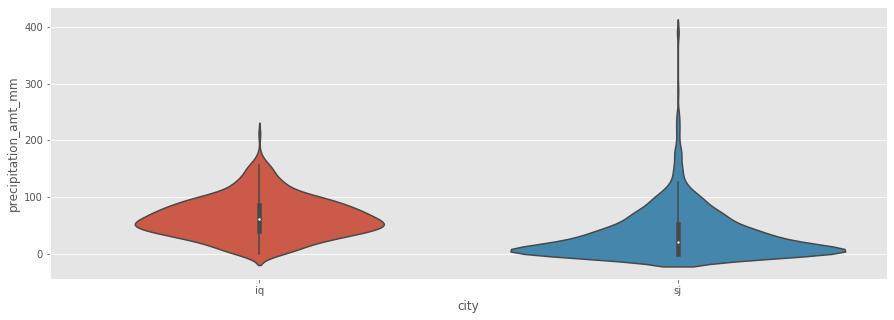

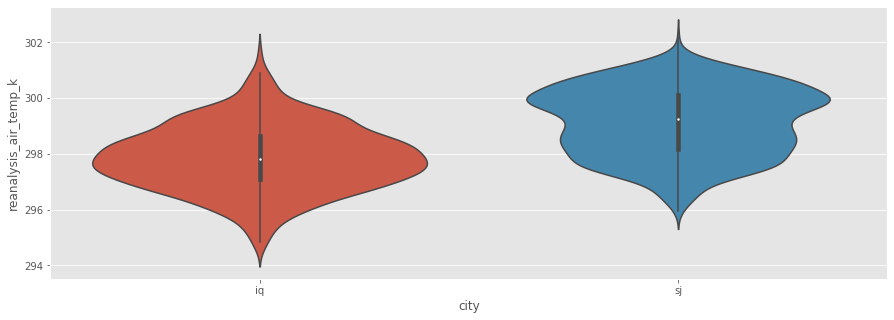

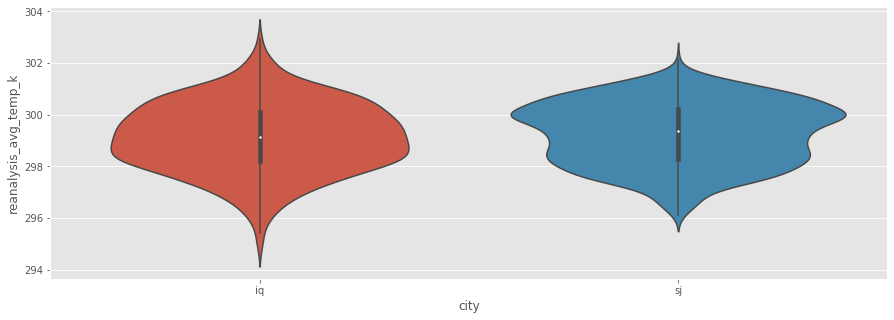

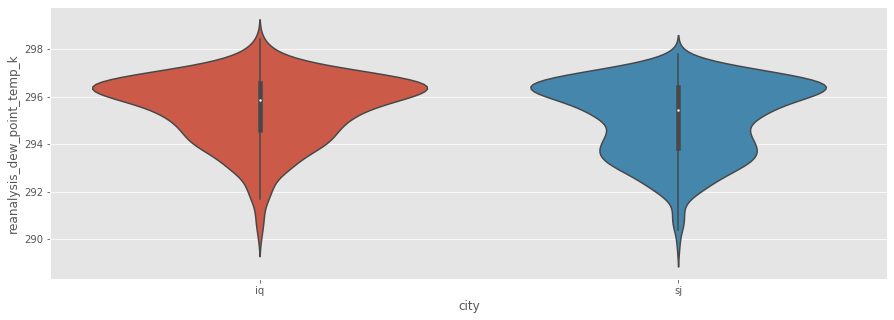

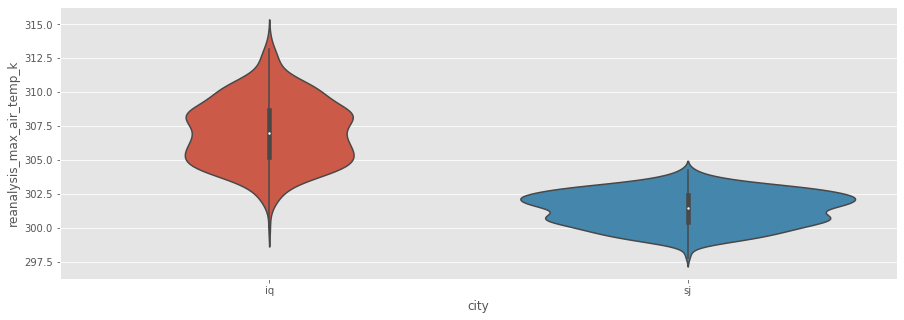

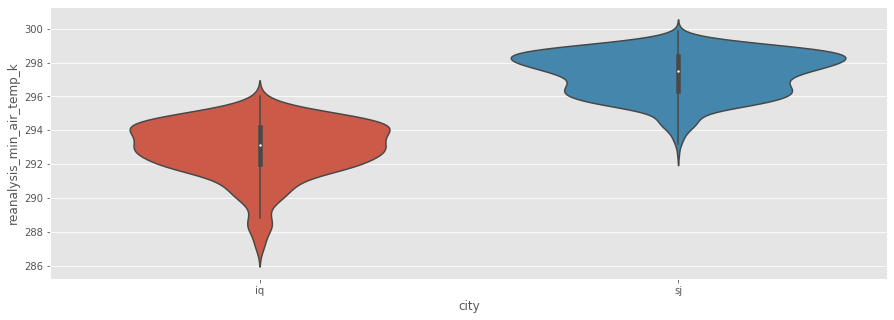

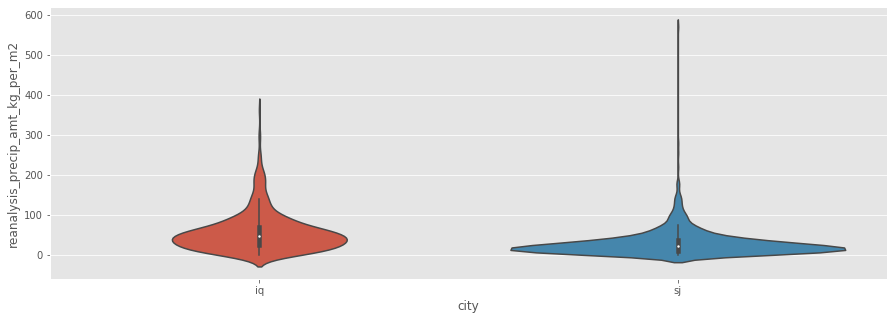

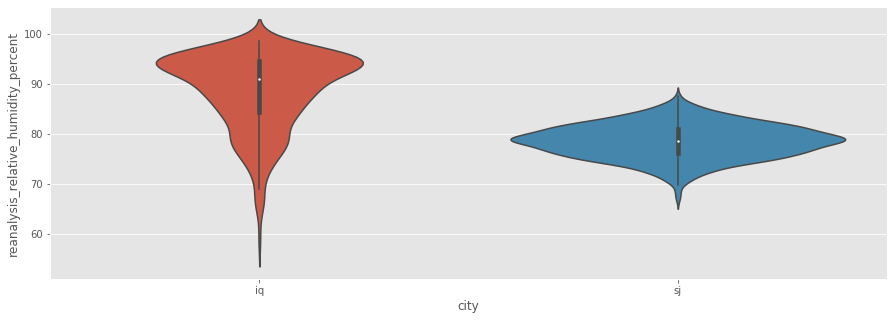

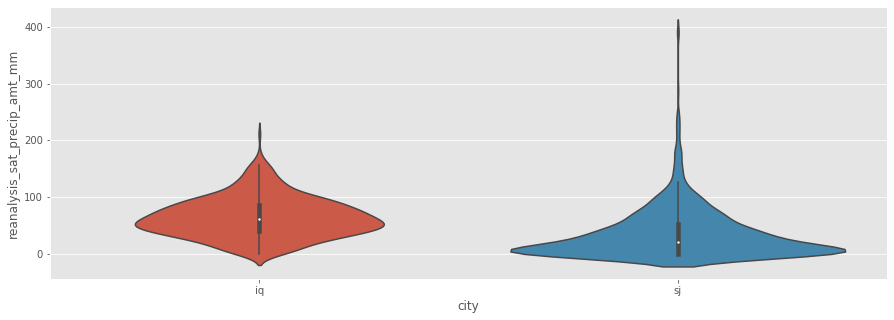

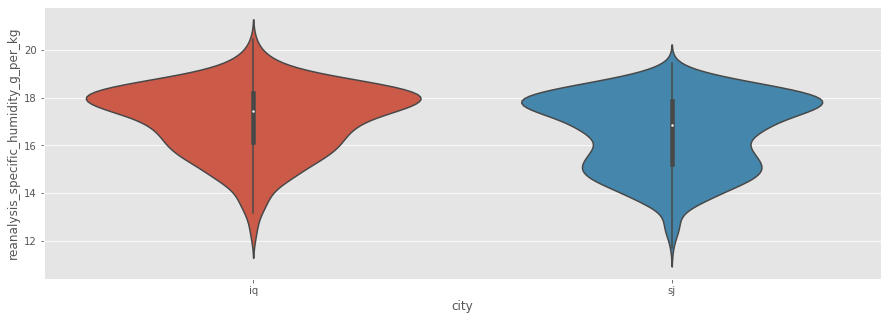

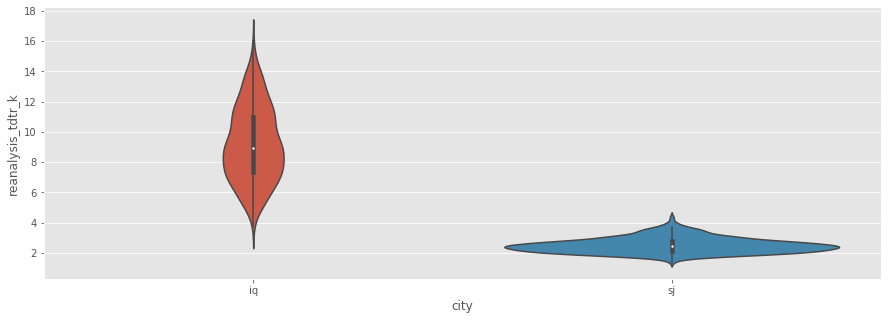

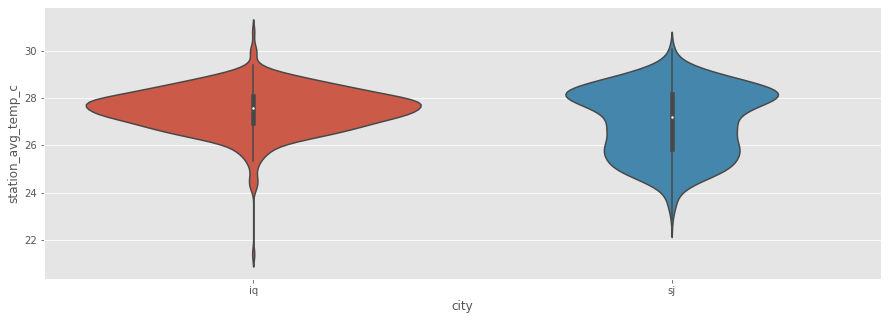

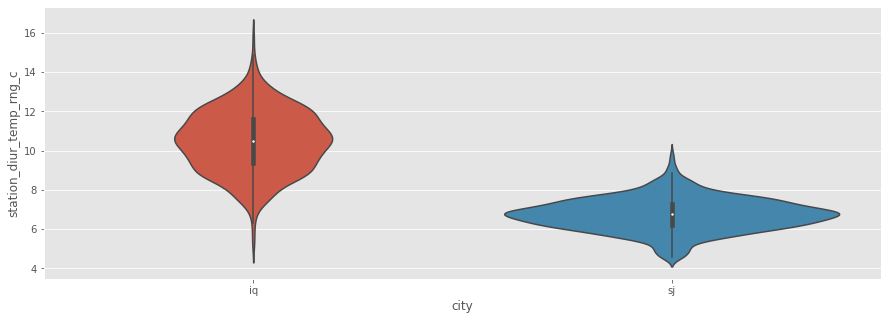

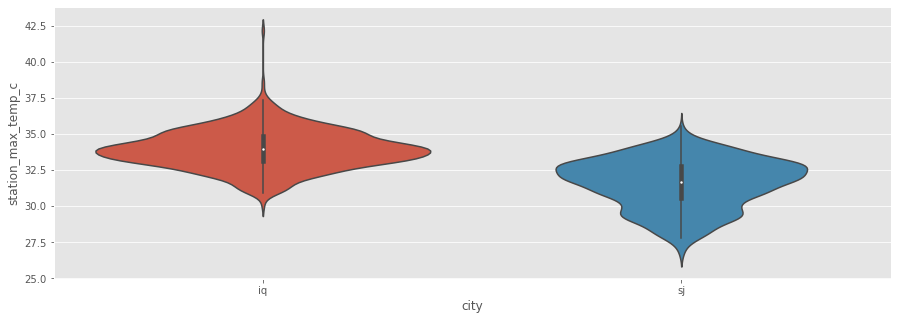

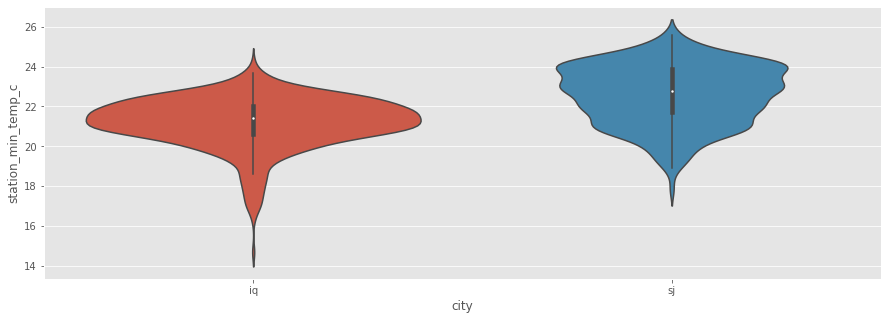

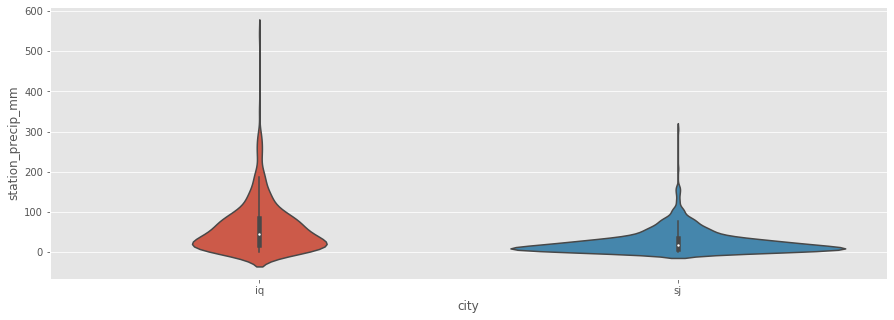

In [25]:
for col in colums_to_iter:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.violinplot('city',col, data=all_train_data, ax=ax)
    plt.show()

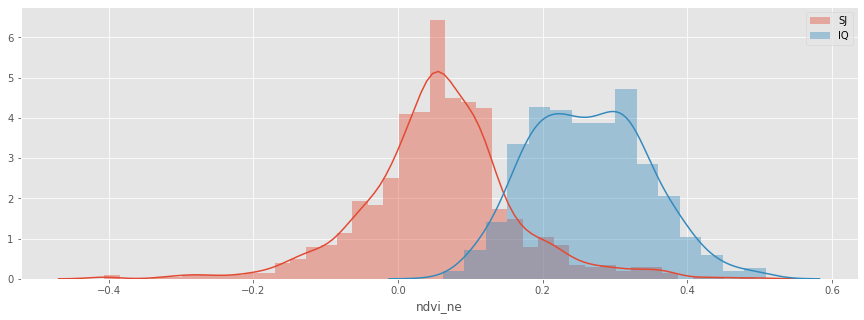

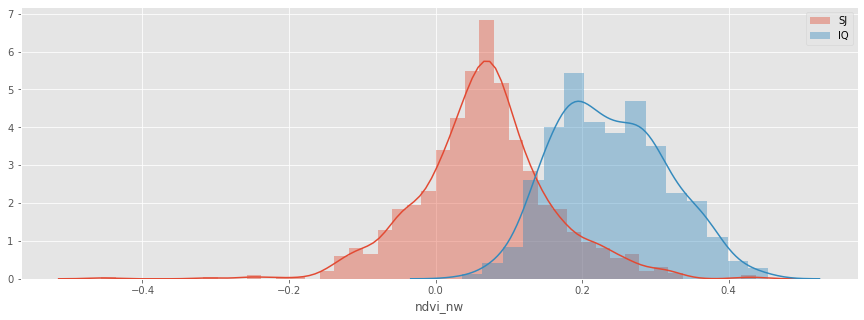

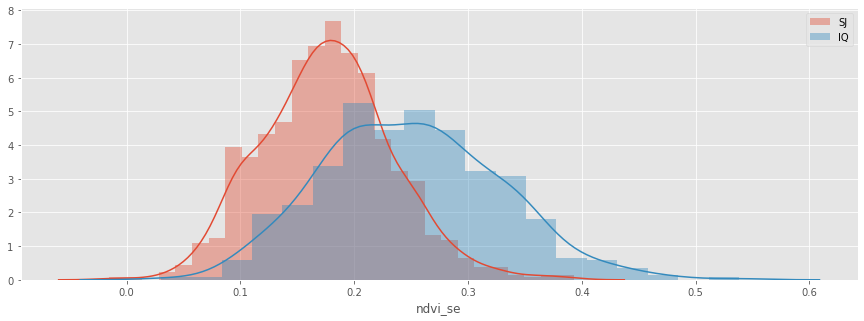

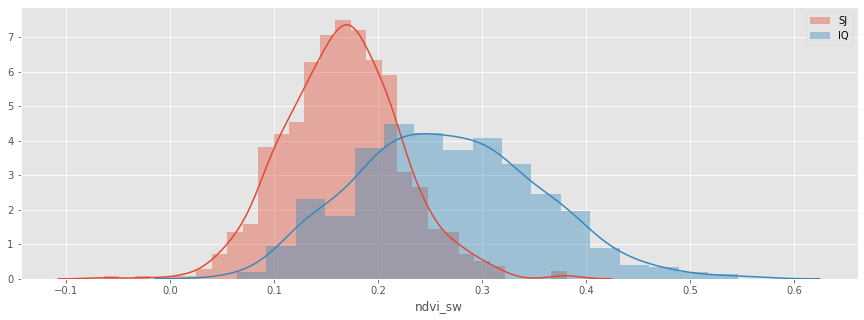

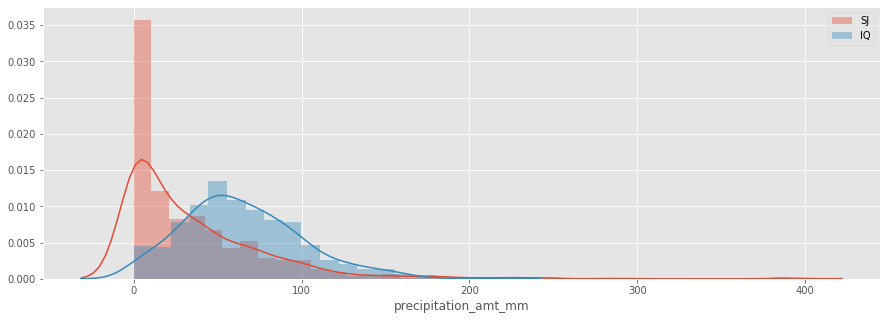

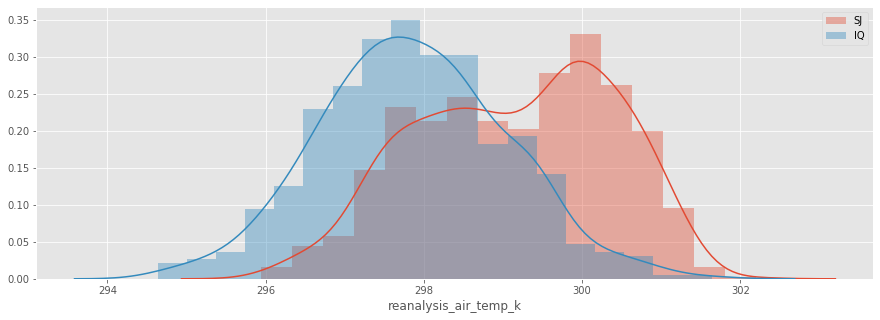

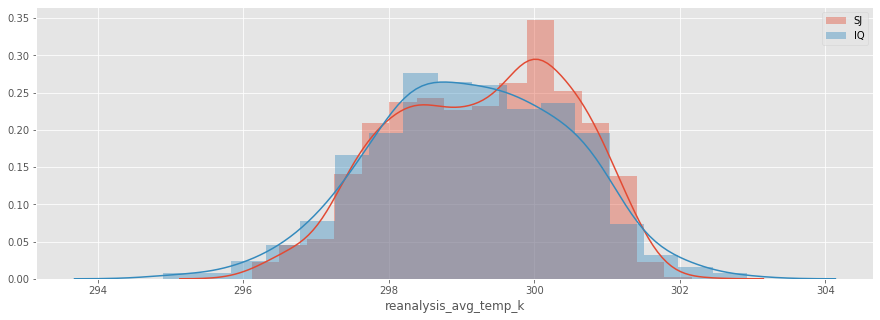

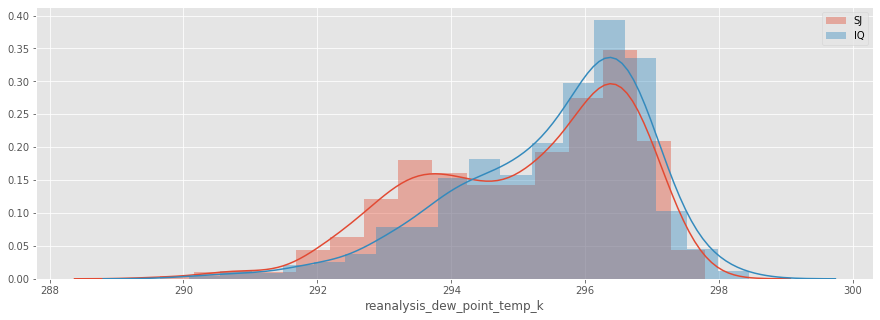

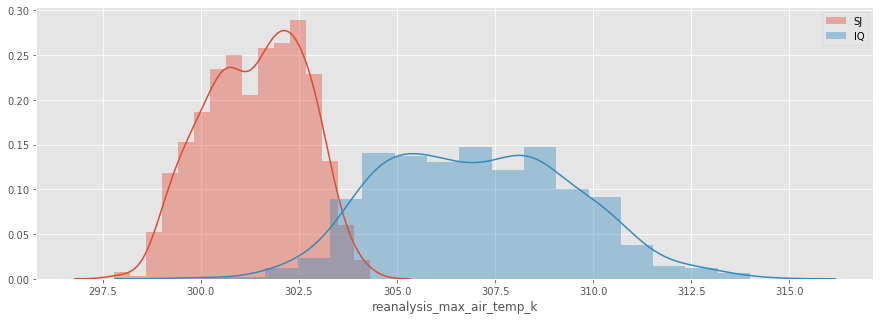

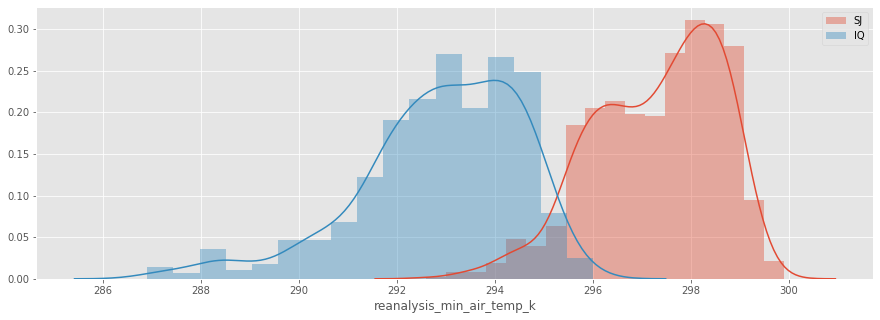

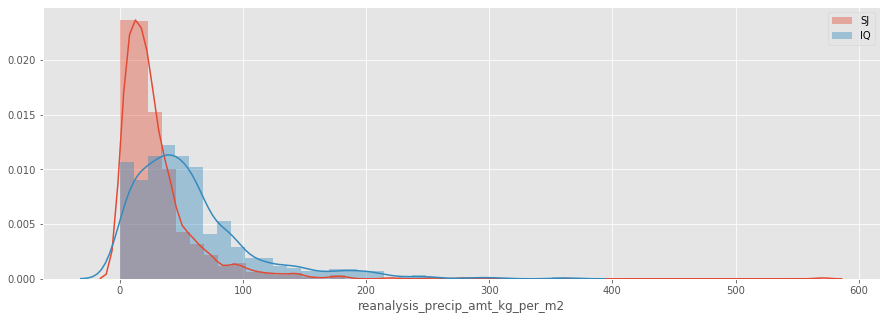

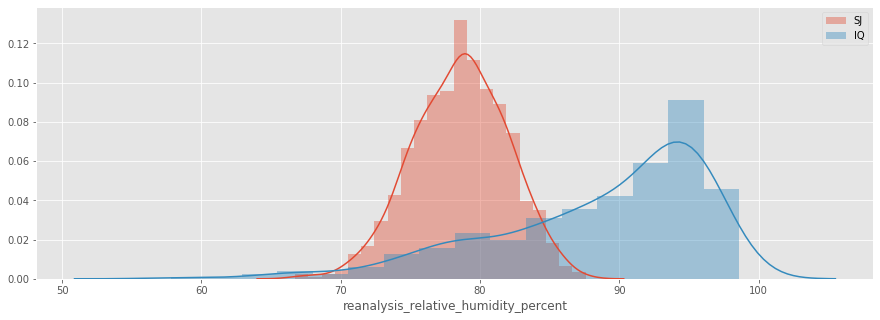

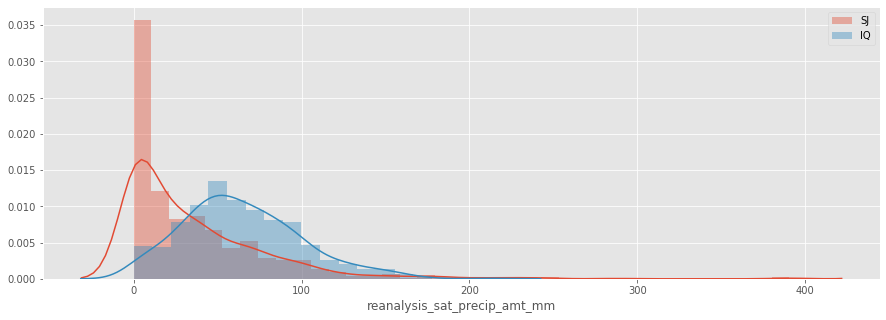

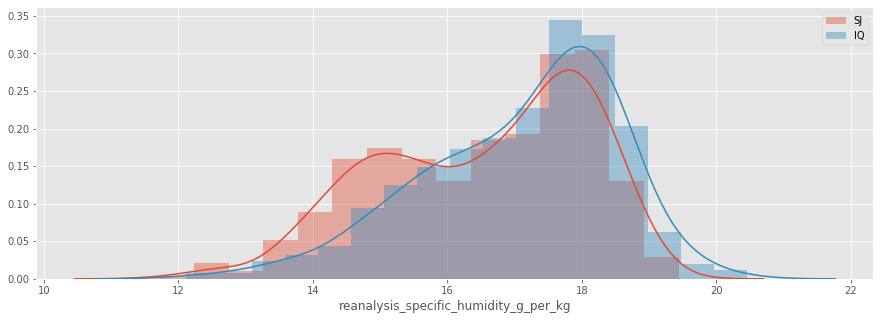

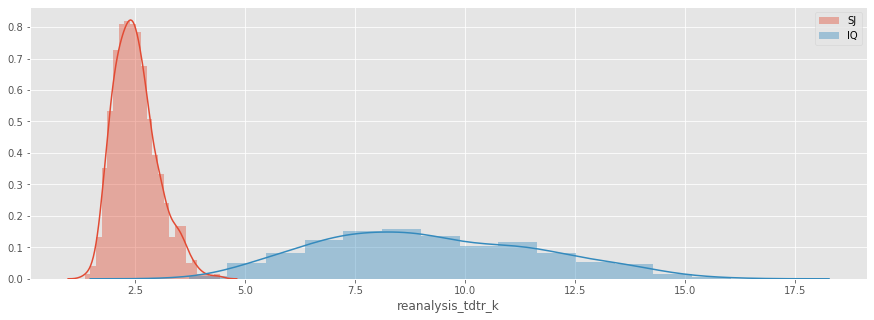

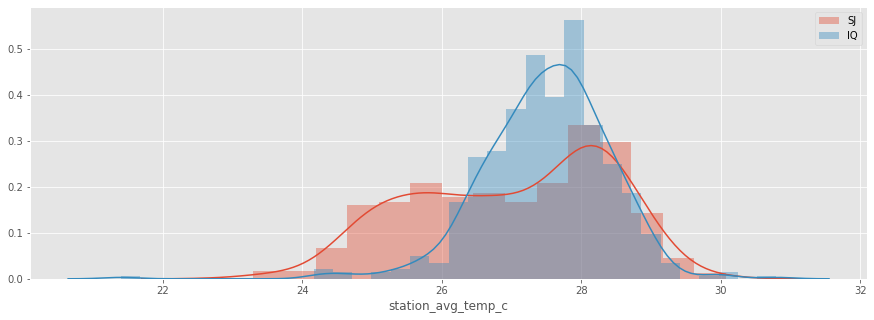

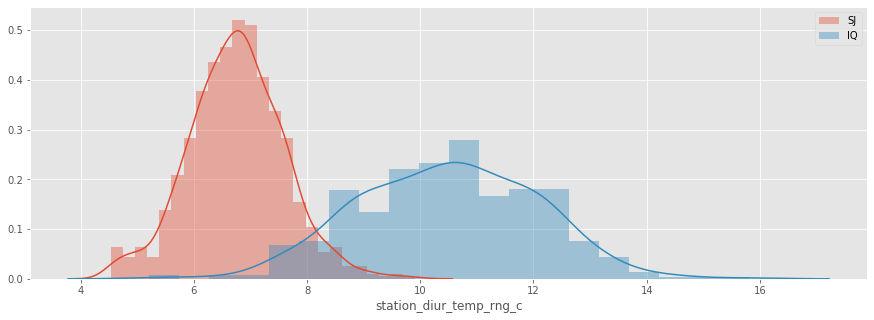

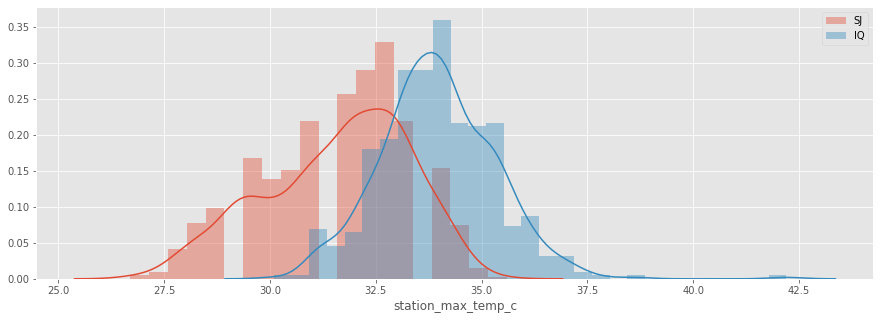

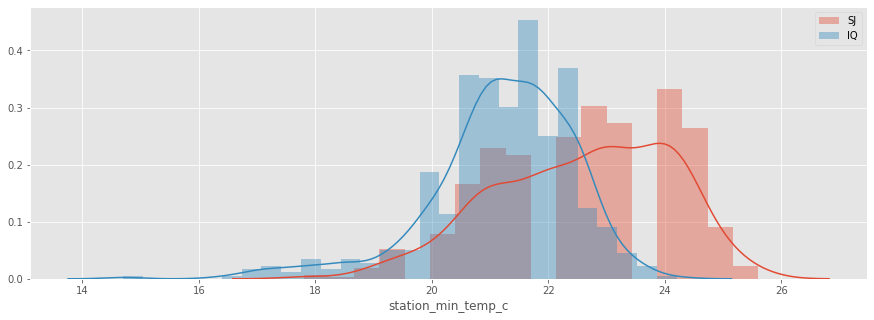

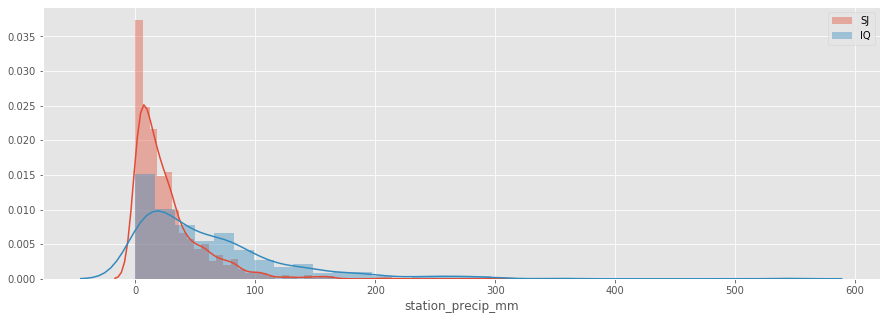

In [26]:
for col in colums_to_iter:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.distplot(sj_train_data[col], ax=ax, label='SJ')
    sns.distplot(iq_train_data[col], ax=ax, label='IQ')
    plt.legend()
    plt.show()

### For training data vs test data in San Juan

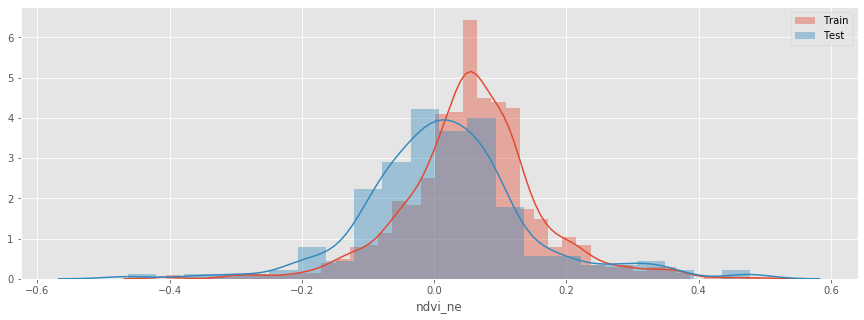

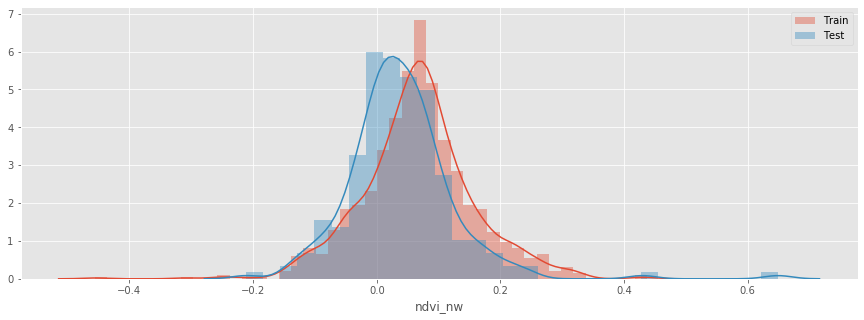

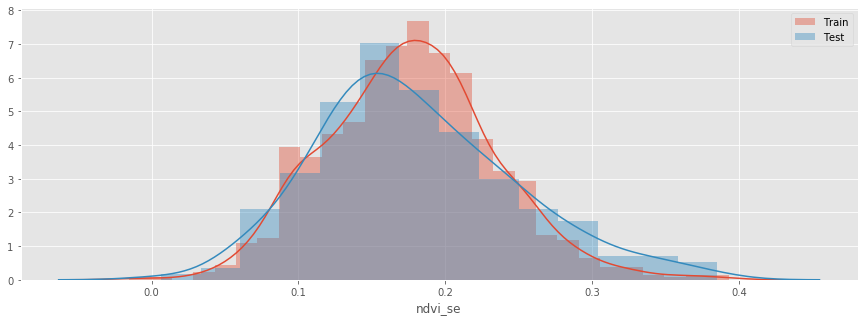

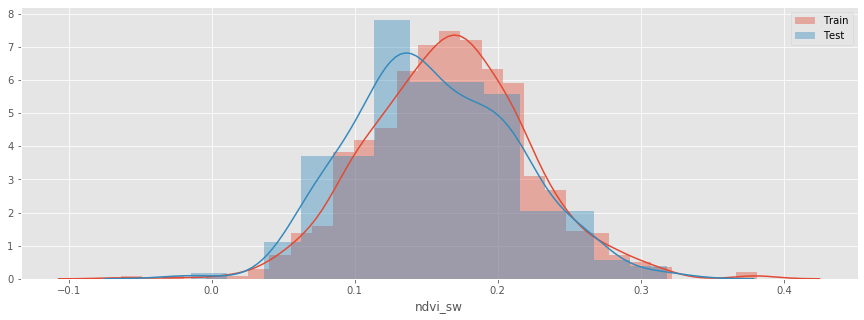

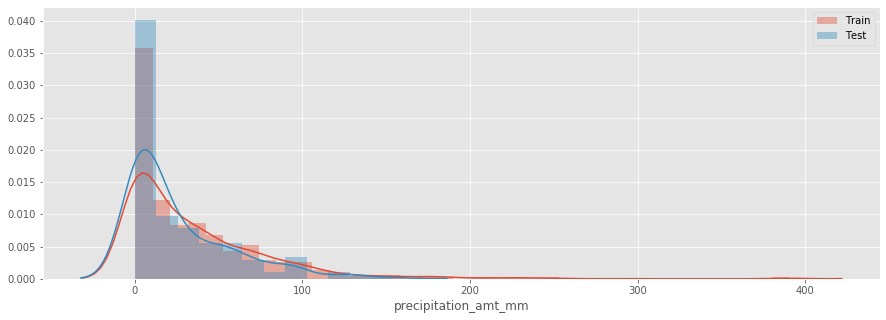

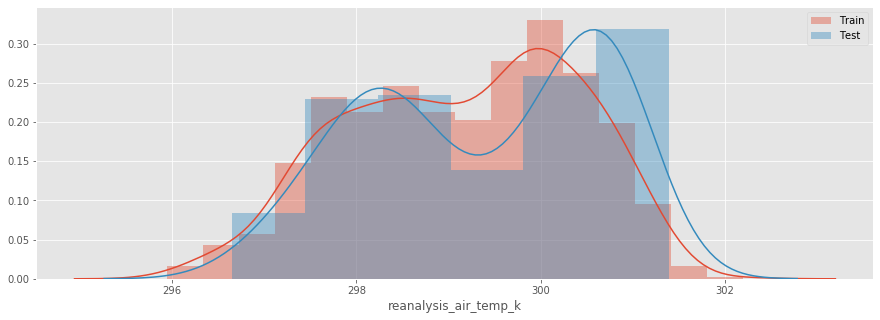

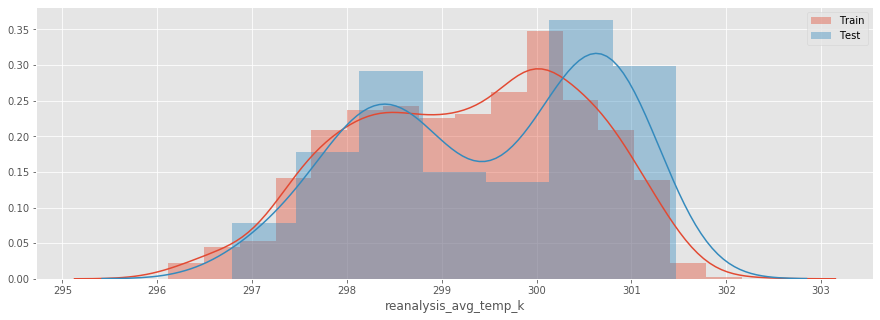

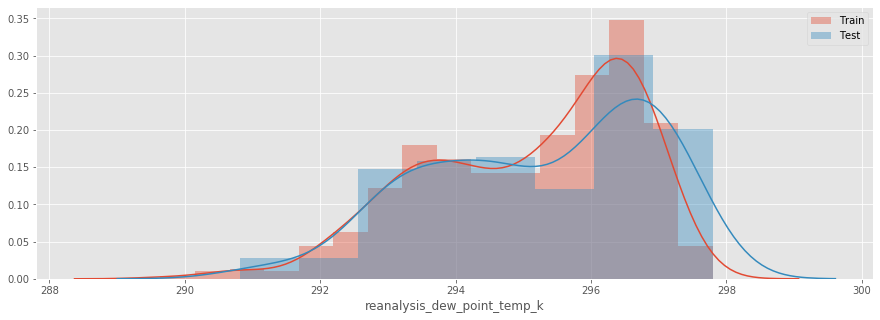

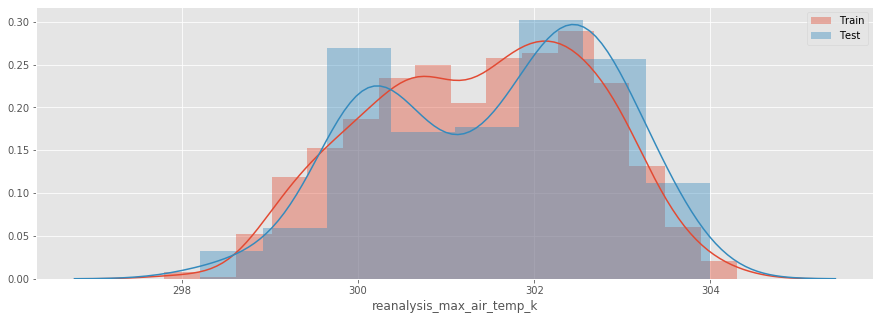

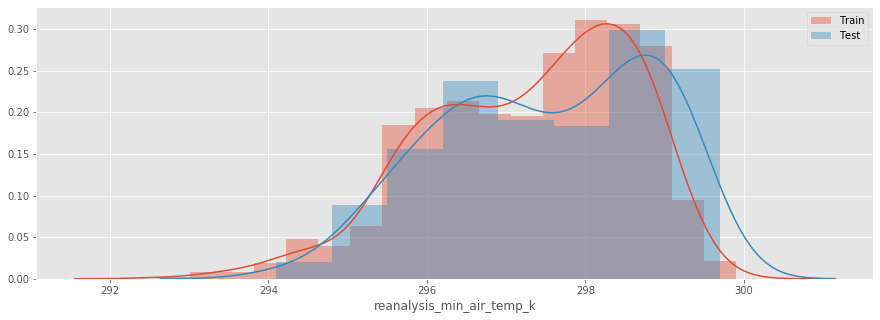

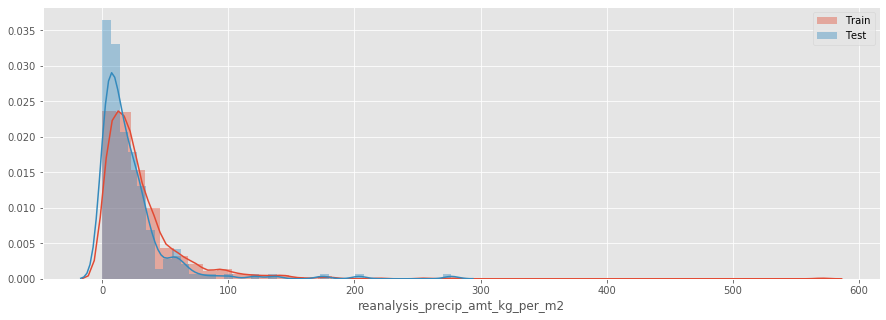

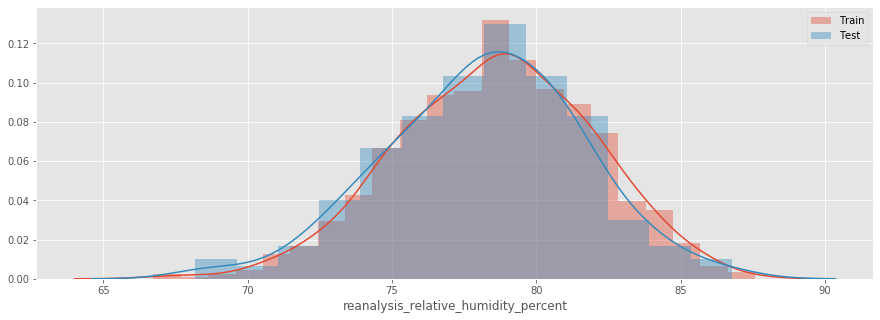

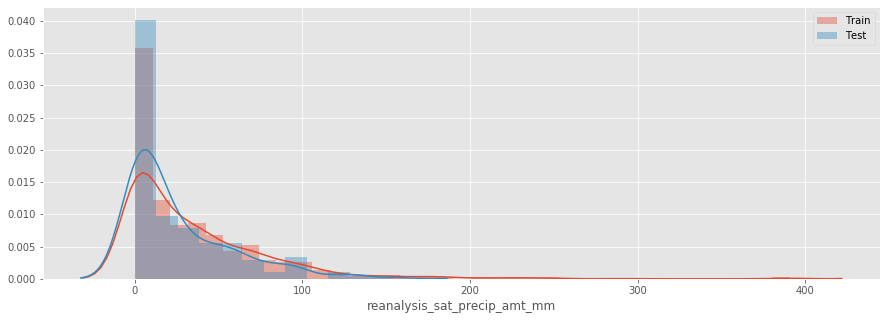

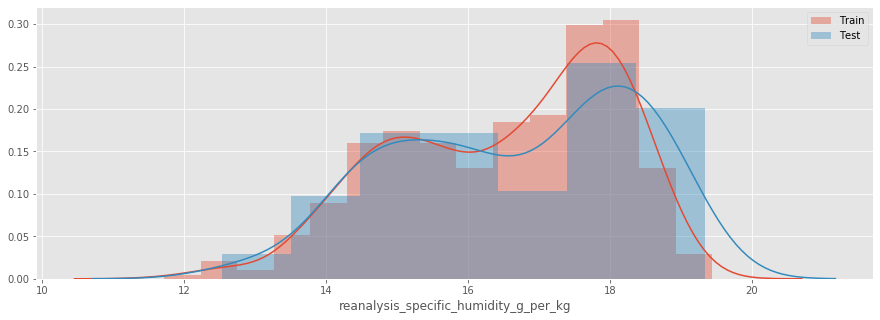

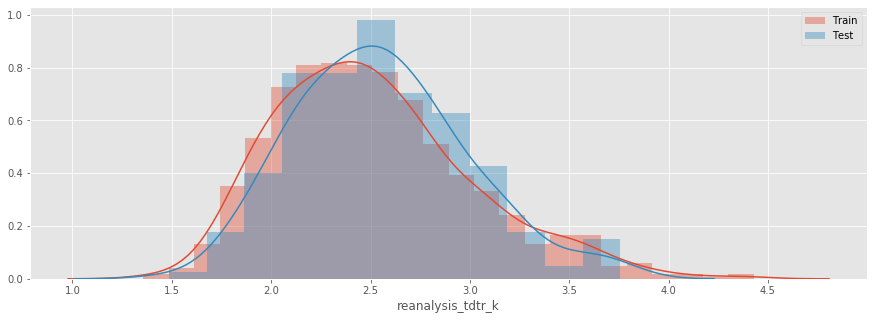

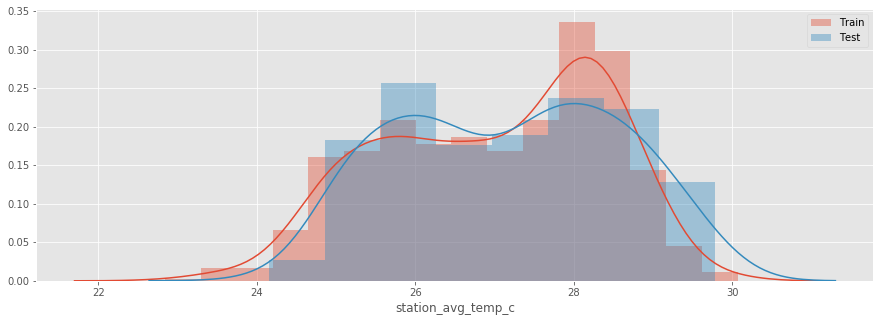

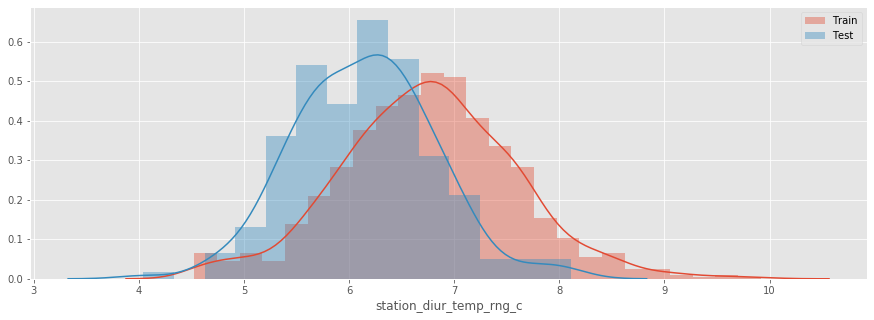

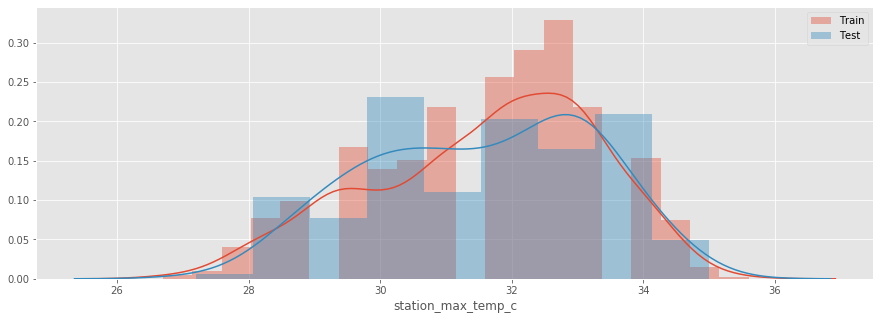

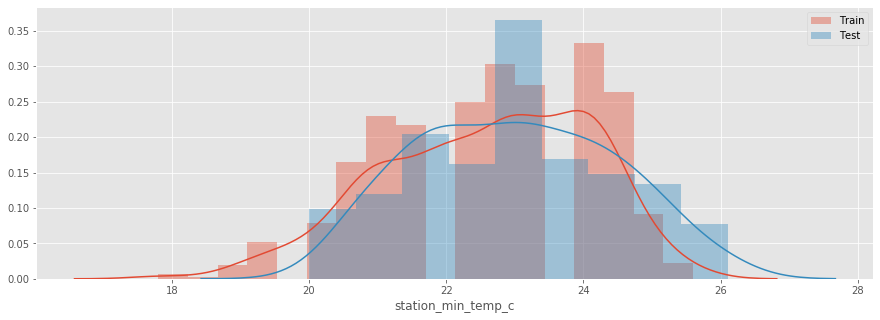

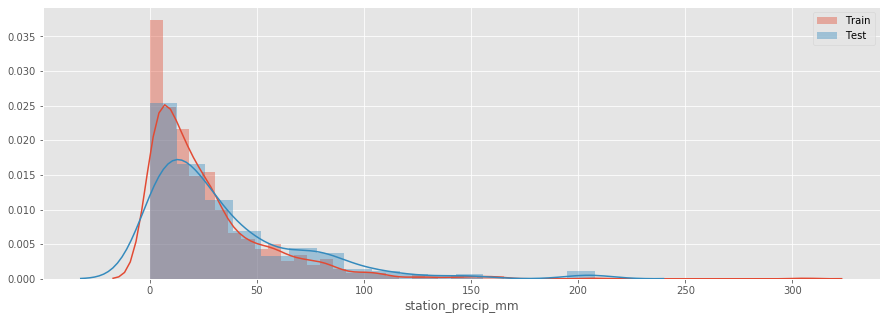

In [27]:
#Dropping creating a copy of the test data with dropped nans
SJ_test_data_droppednans = all_data[(all_data['city']=='sj') & (all_data['set_type'] == 'test')].drop('total_cases', axis=1).dropna()

for col in colums_to_iter:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.distplot(sj_train_data[col], ax=ax, label='Train')
    sns.distplot(SJ_test_data_droppednans[col], ax=ax, label='Test')
    plt.legend()
    plt.show()

### For training data vs test data in Iquitos

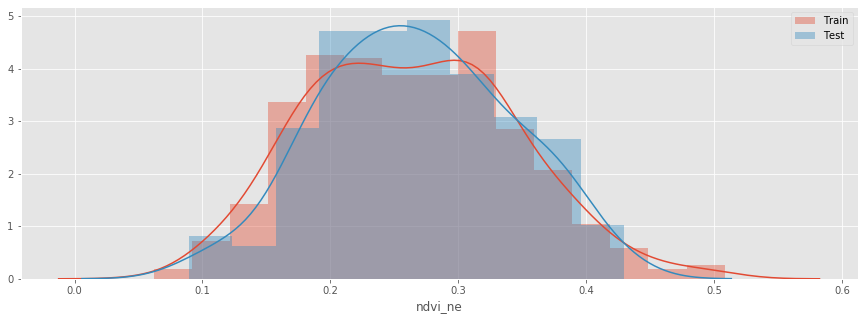

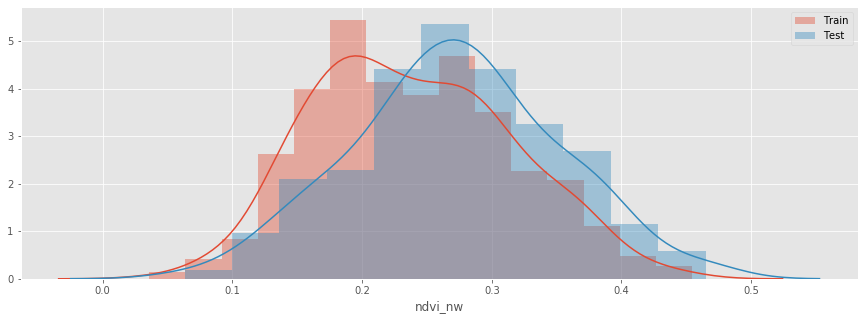

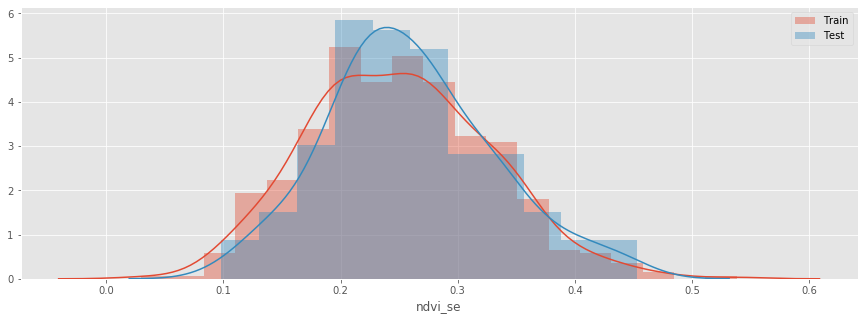

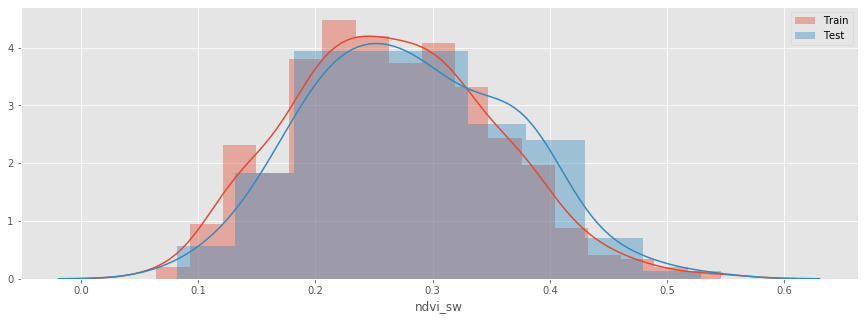

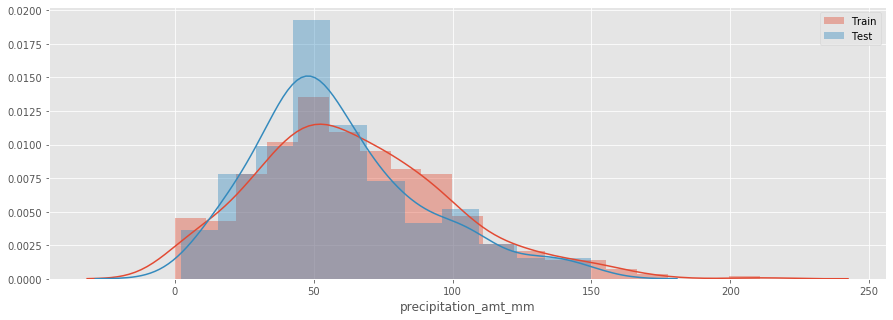

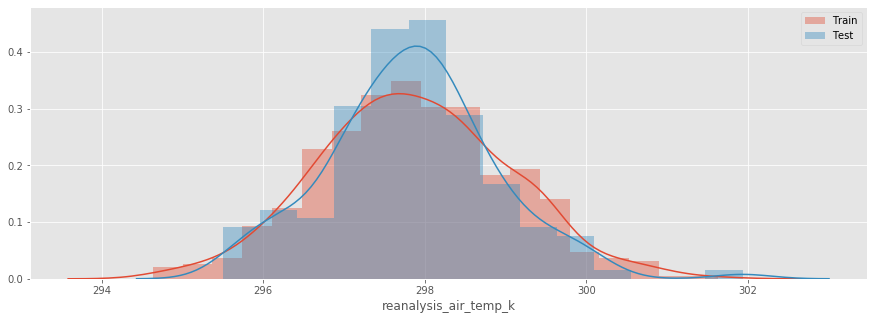

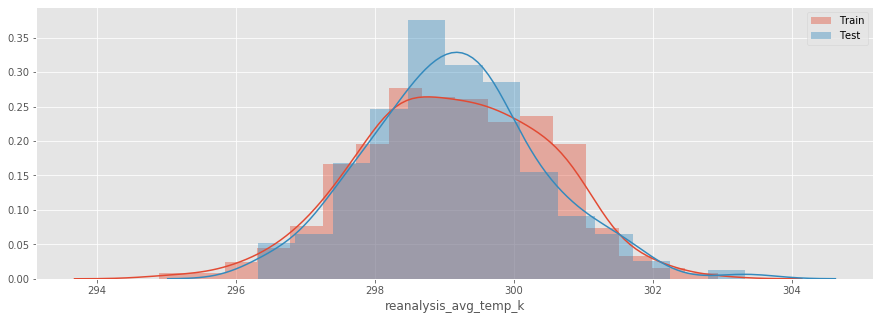

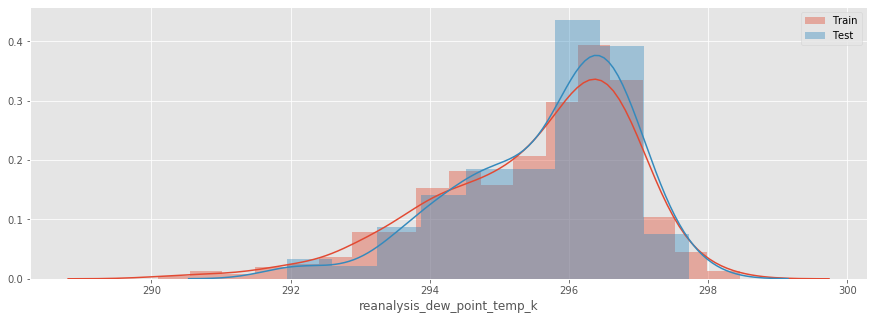

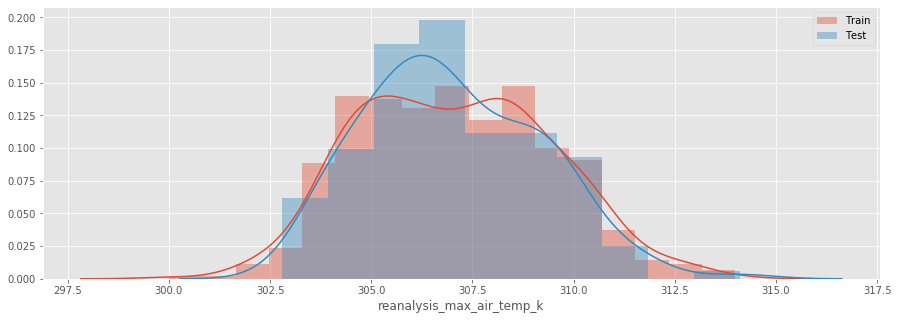

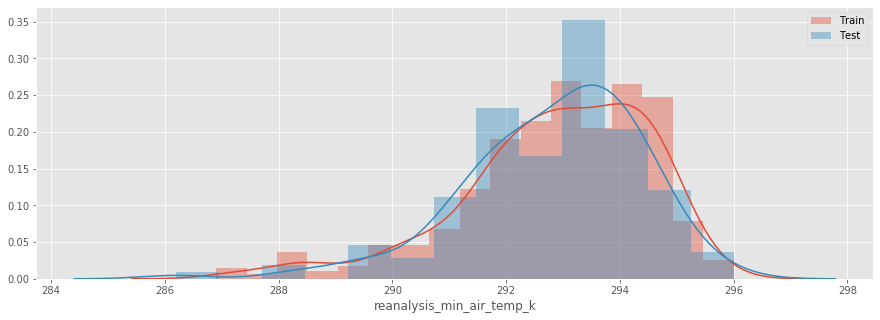

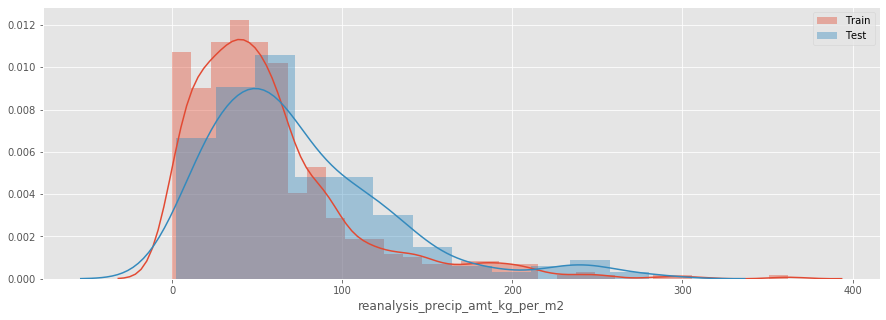

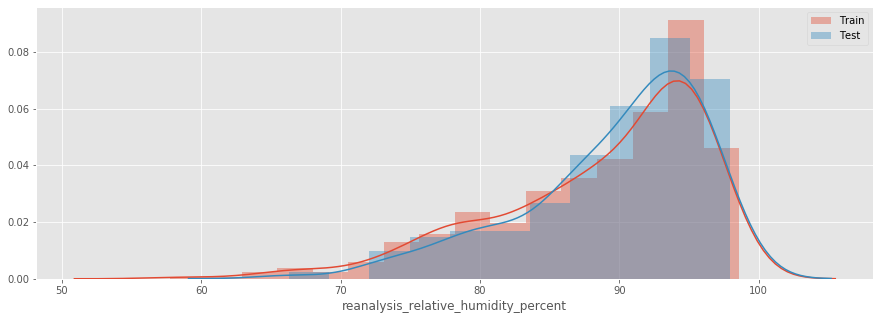

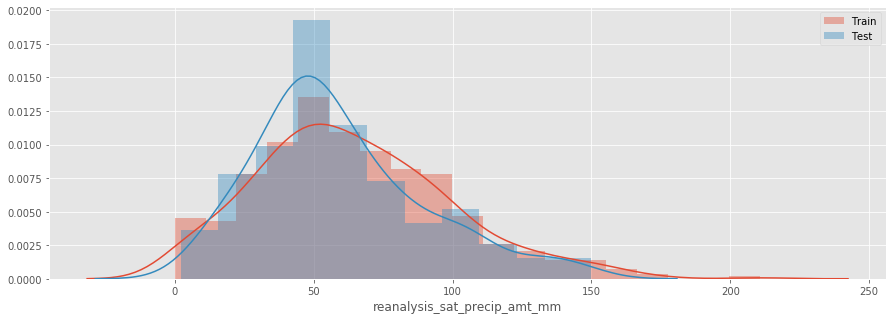

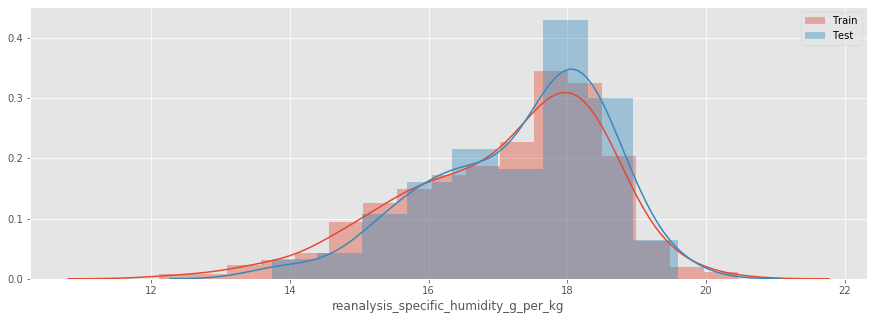

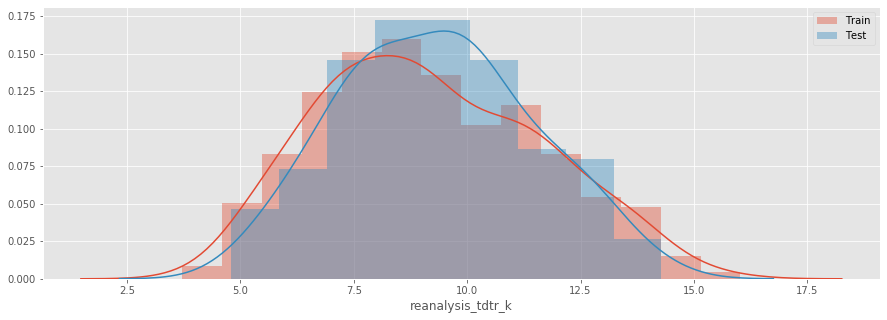

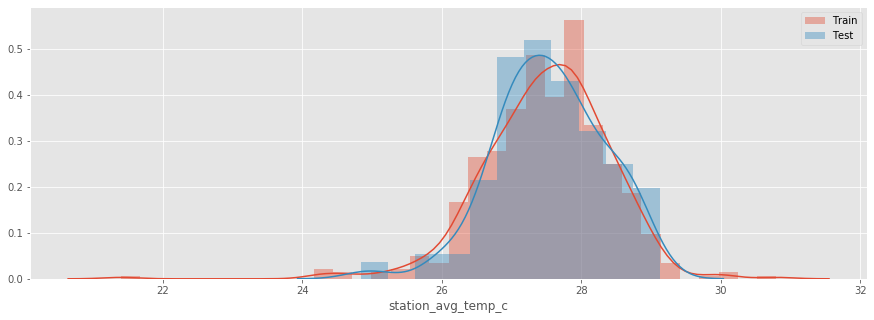

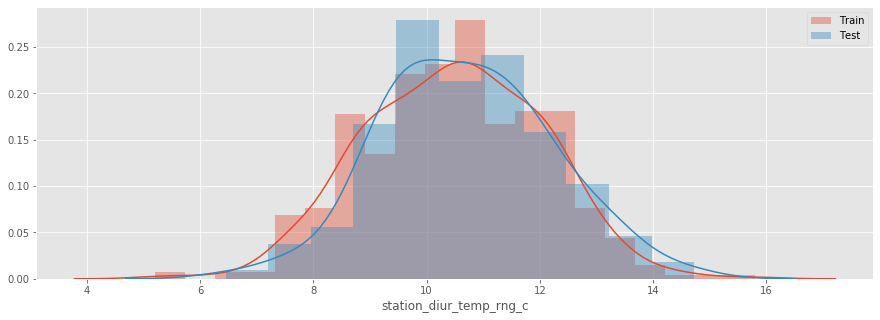

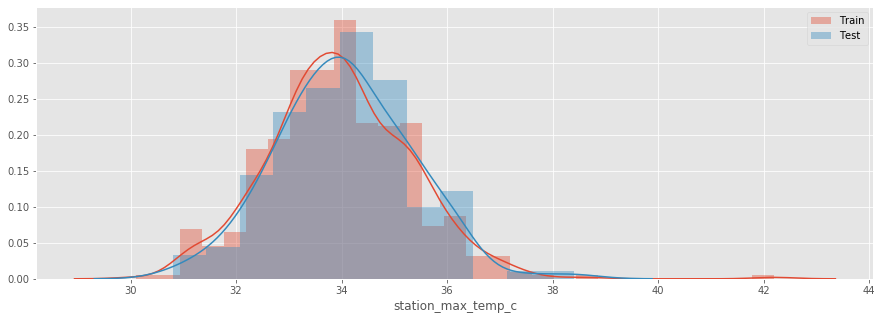

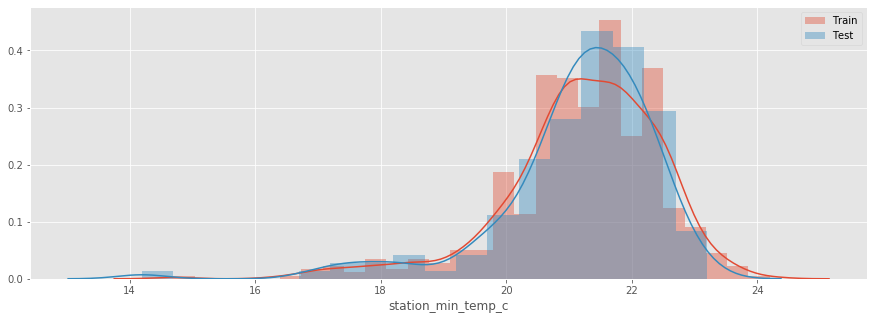

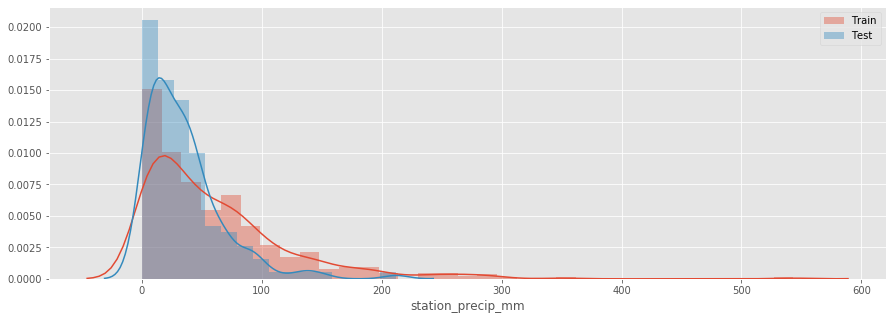

In [28]:
#Dropping creating a copy of the test data with dropped nans
IQ_test_data_droppednans = all_data[(all_data['city']=='iq') & (all_data['set_type'] == 'test')].drop('total_cases', axis=1).dropna()

for col in colums_to_iter:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.distplot(iq_train_data[col], ax=ax, label='Train')
    sns.distplot(IQ_test_data_droppednans[col], ax=ax, label='Test')
    plt.legend()
    plt.show()

# Distribution of Data Conclusion

By doing a distribution plot on the training data of both cities, it is better to see why it is important to separate them. They are not distributed equally, thus could disturb the machine learning process later on.
\
\
Adding more to this case, are the Train and Test distribution plots of each cities. This way we can see the relationship of how climate changes in those cities, meaning that the test/train data of each respective city is more equally distributed because they belong on the same place.

# Change of total cases with time

C:\Users\HGSM\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


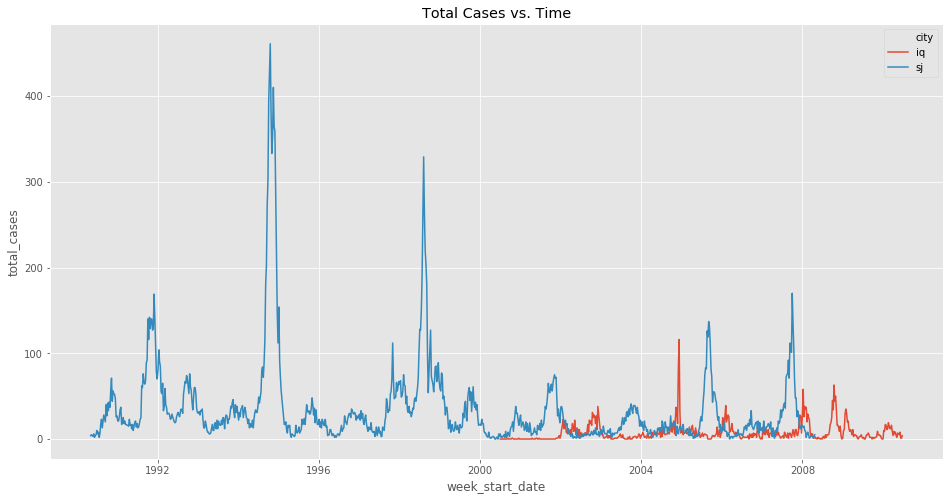

In [29]:
#using datetime as index
date_all_train_data = all_train_data.set_index(all_train_data.week_start_date)
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot('week_start_date','total_cases',hue='city',data=all_train_data, ax=ax)
plt.title('Total Cases vs. Time')
plt.show()

### Yearly cases

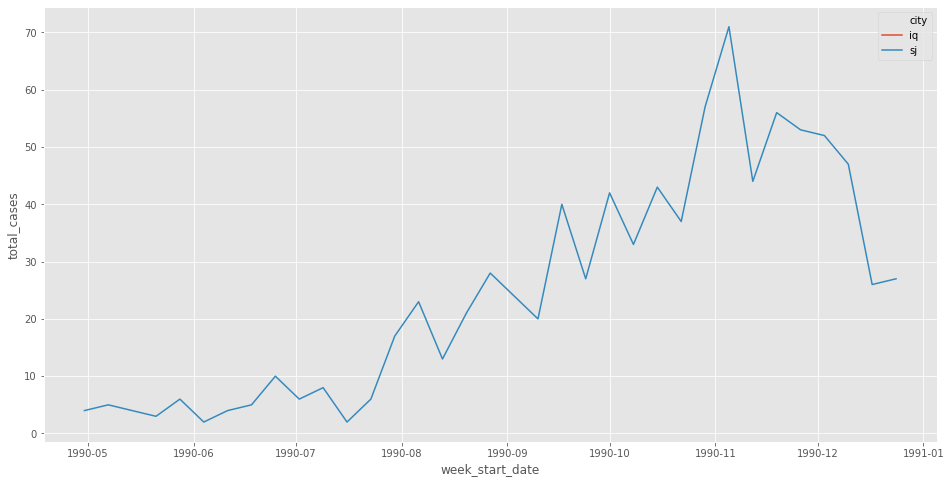

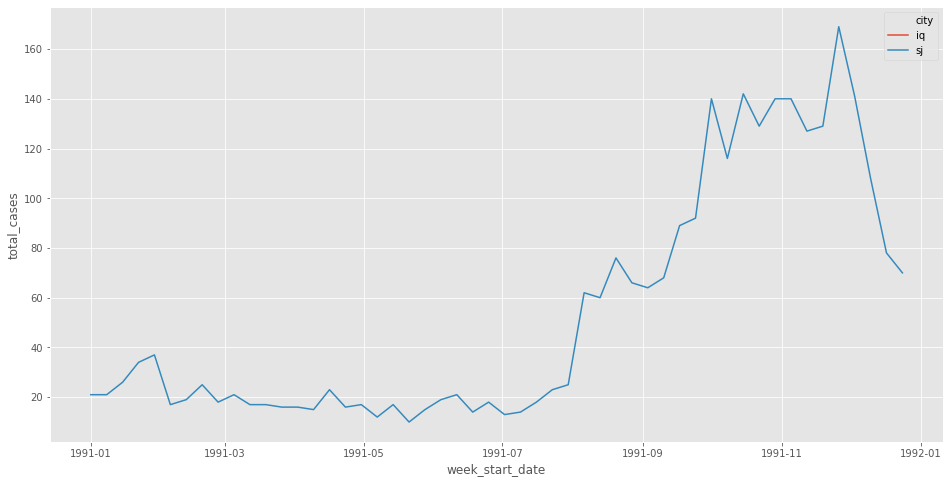

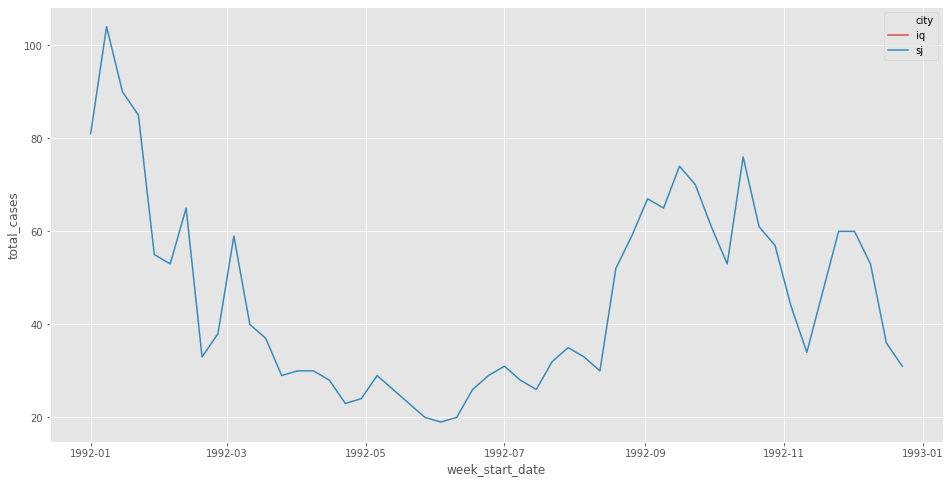

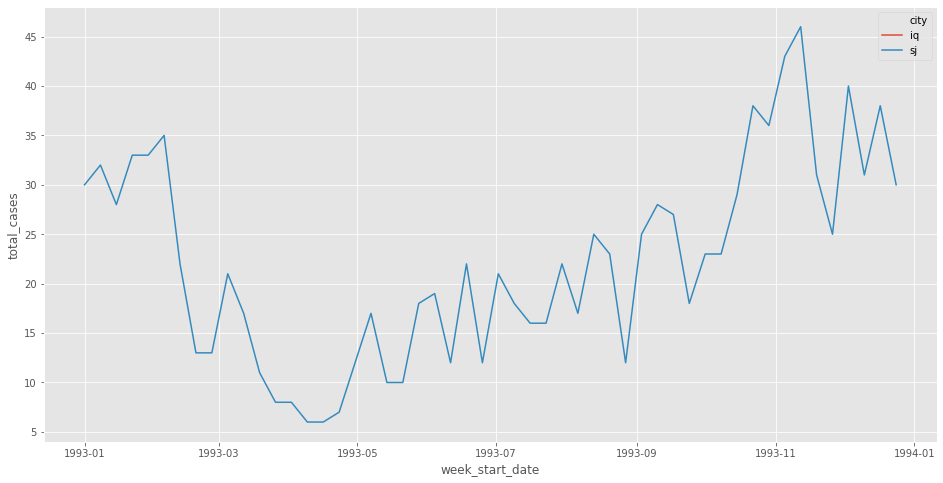

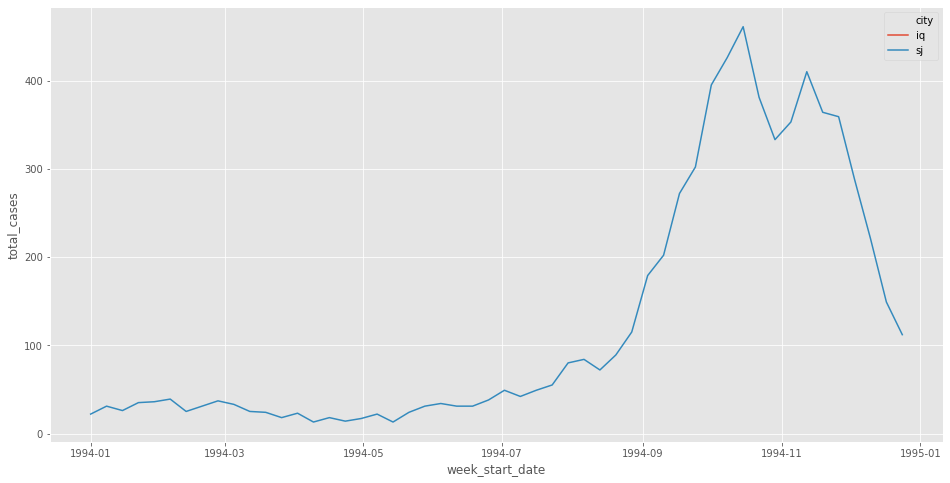

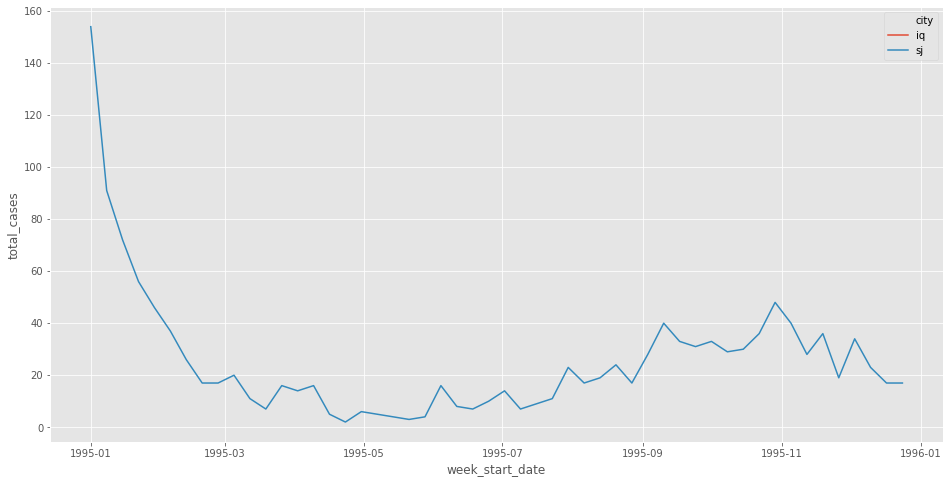

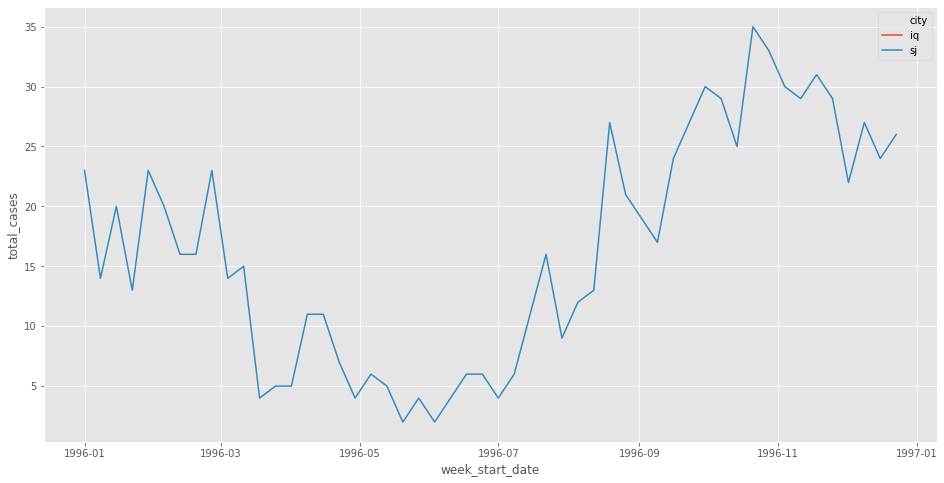

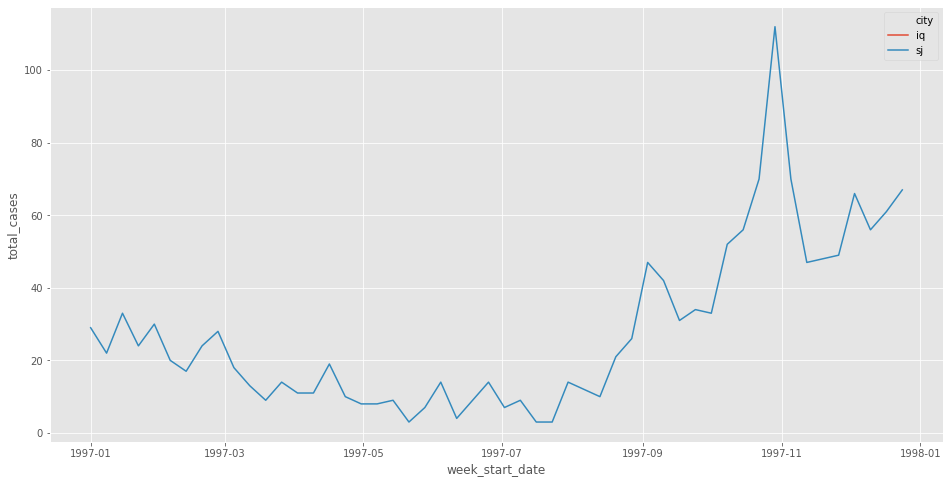

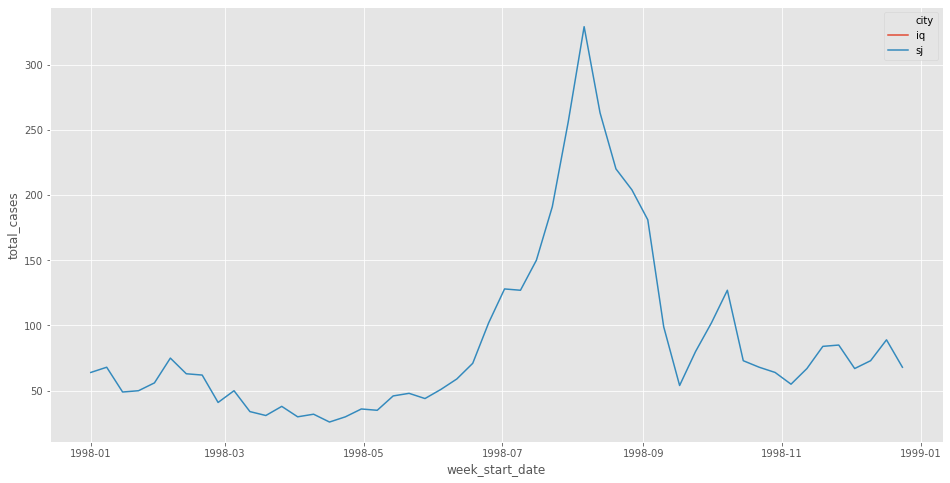

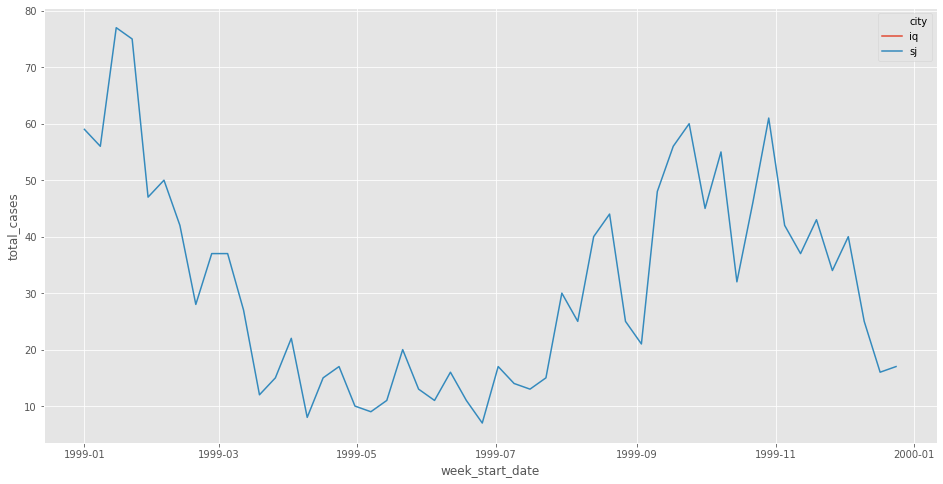

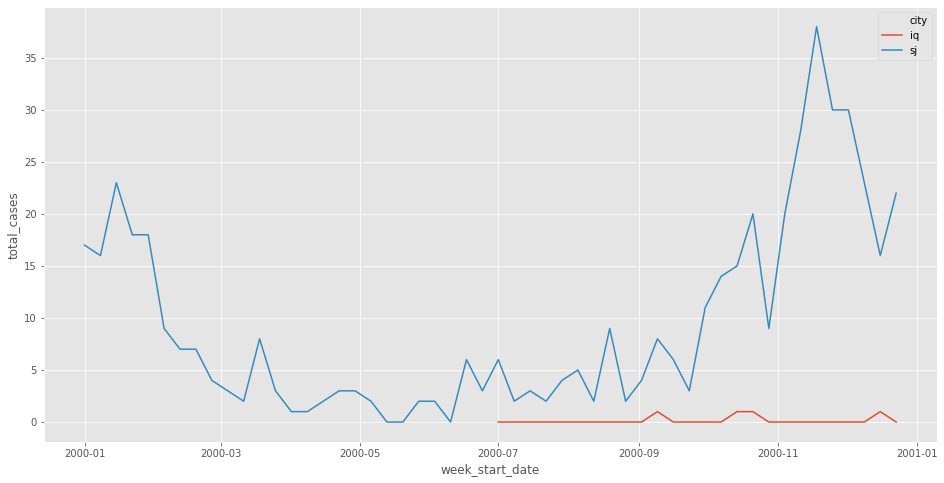

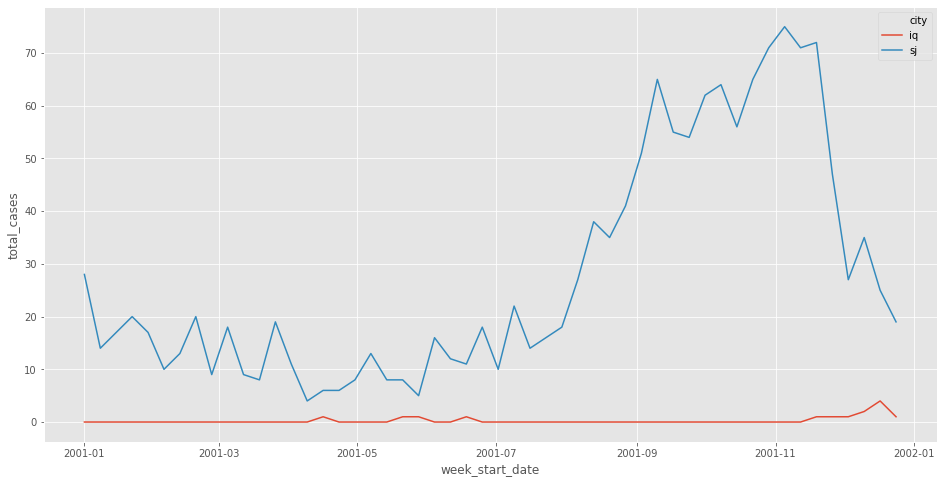

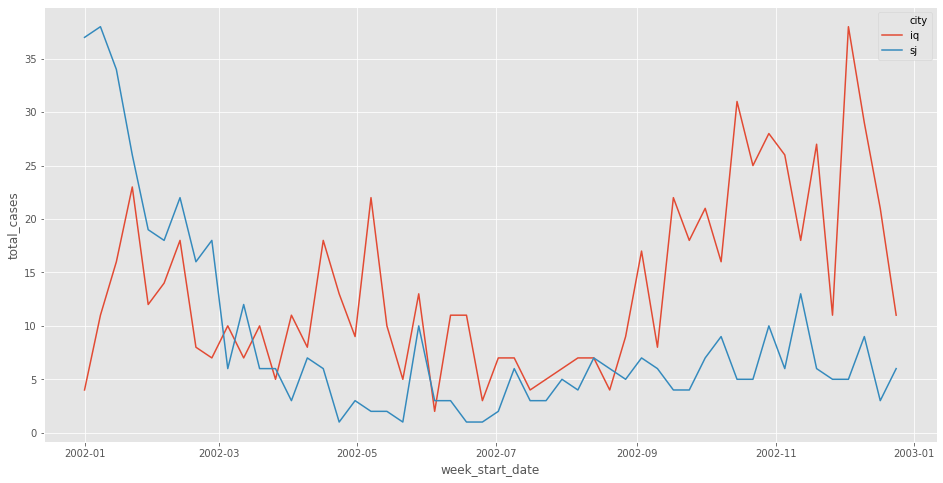

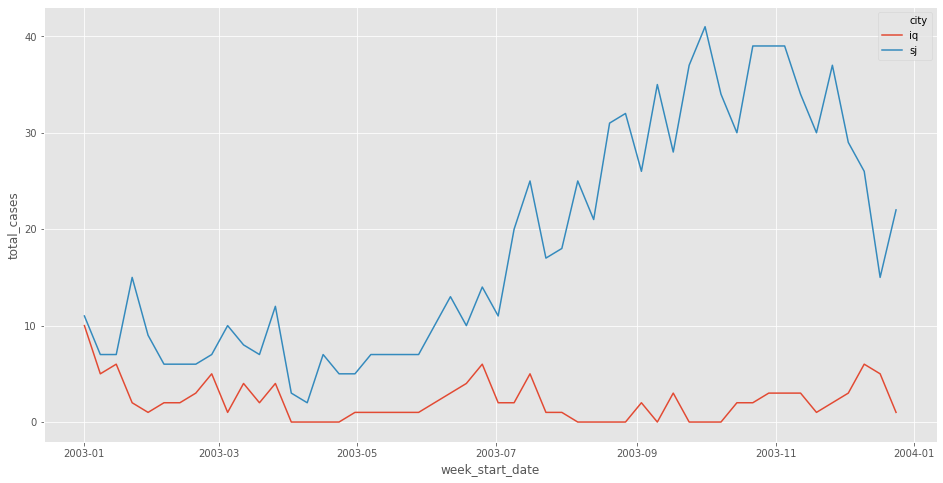

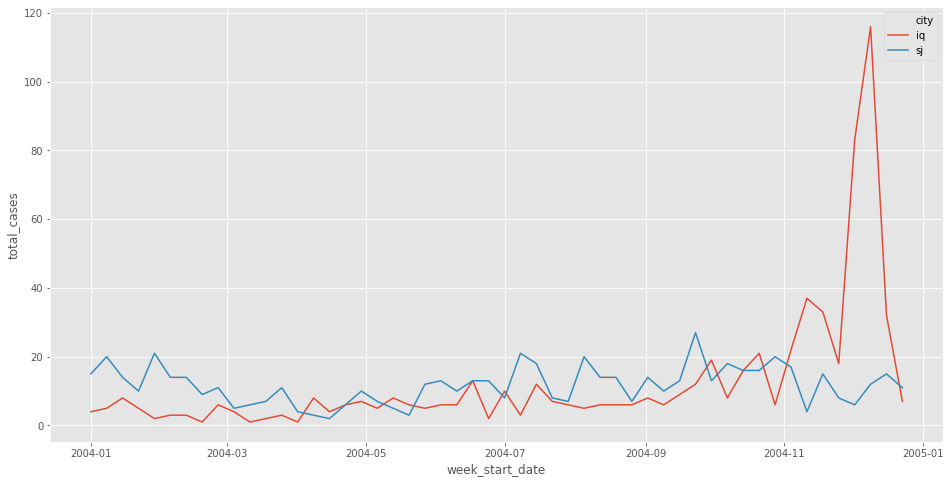

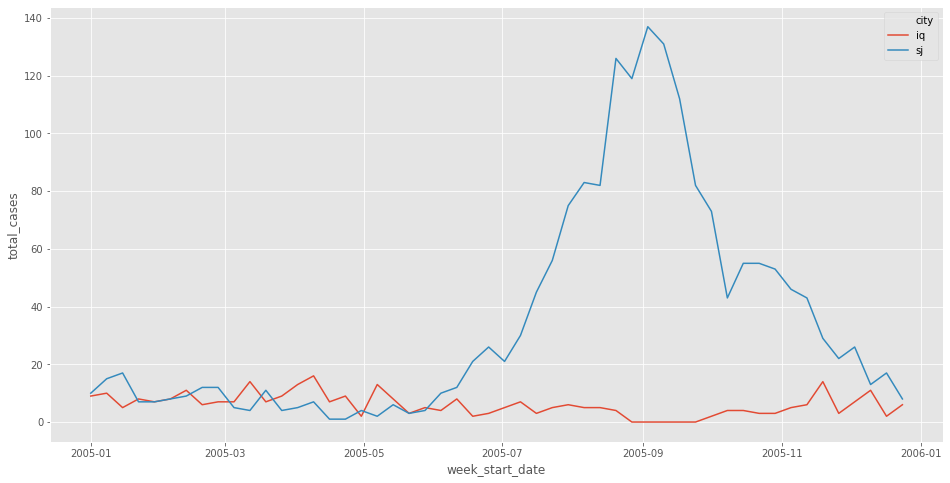

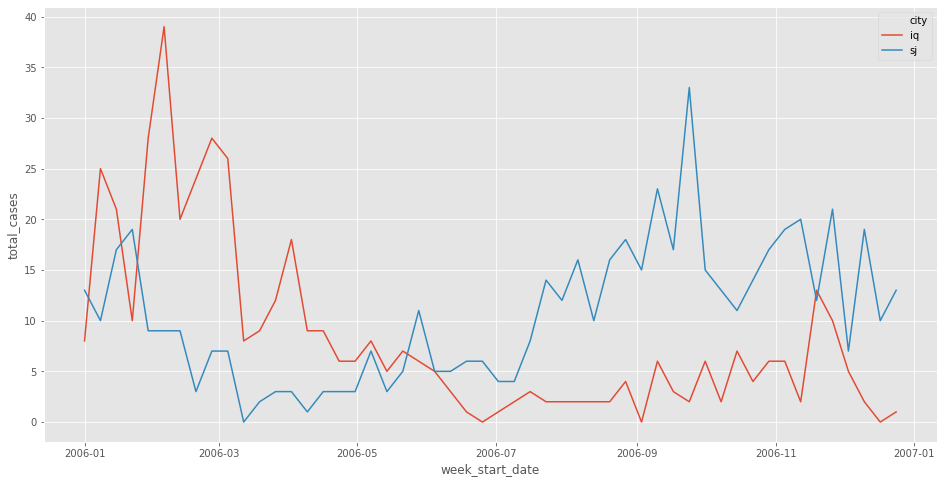

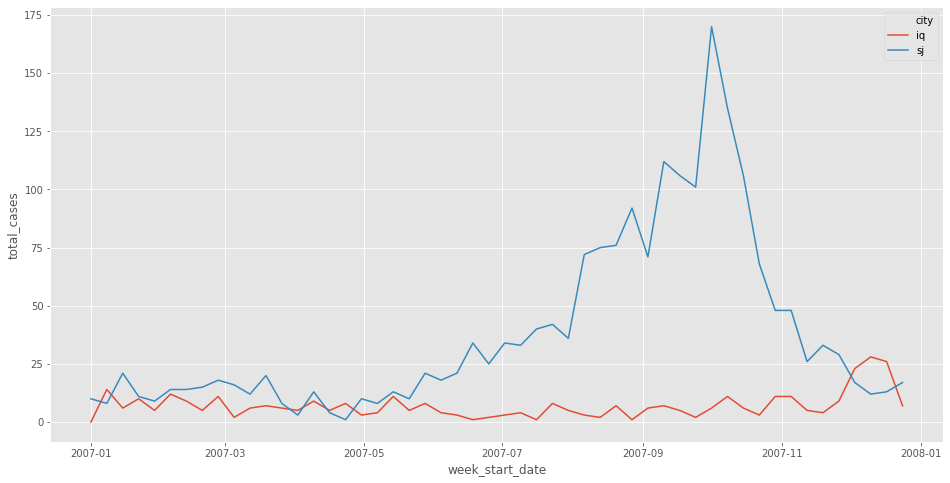

In [30]:
for i in range(1990,2008):
    fig, ax = plt.subplots(figsize=(16,8))
    sns.lineplot('week_start_date','total_cases',hue='city',
                 data=date_all_train_data.loc[str(i)], ax=ax)
    plt.plot()

In [31]:
mean_sj_cases_week = sj_train_data.groupby('weekofyear').mean()

Text(0.5, 1.0, 'Mean Dengue Casese per week in San Juan')

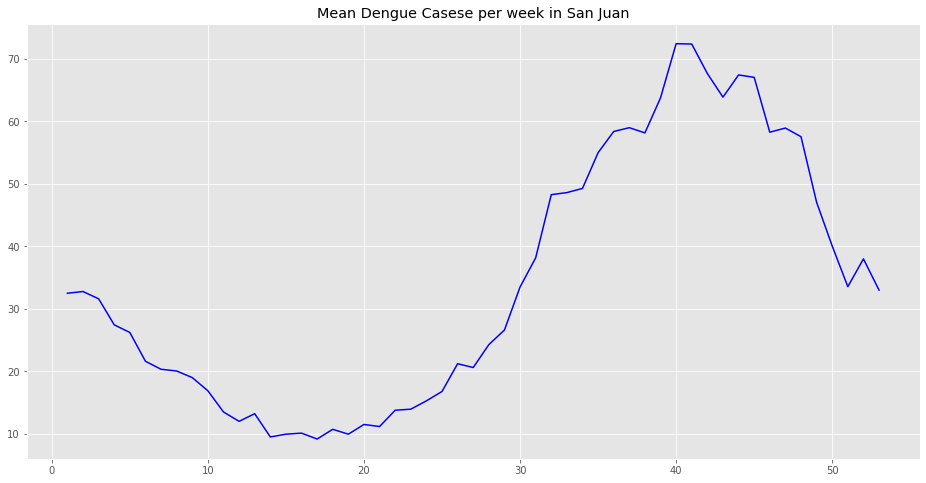

In [77]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(mean_sj_cases_week.index.values, mean_sj_cases_week.total_cases.values,color='blue', ax=ax)
plt.title('Mean Dengue Casese per week in San Juan')

In [33]:
mean_iq_cases_week = iq_train_data.groupby('weekofyear').mean()

Text(0.5, 1.0, 'Mean Dengue Cases per week in Iquitos')

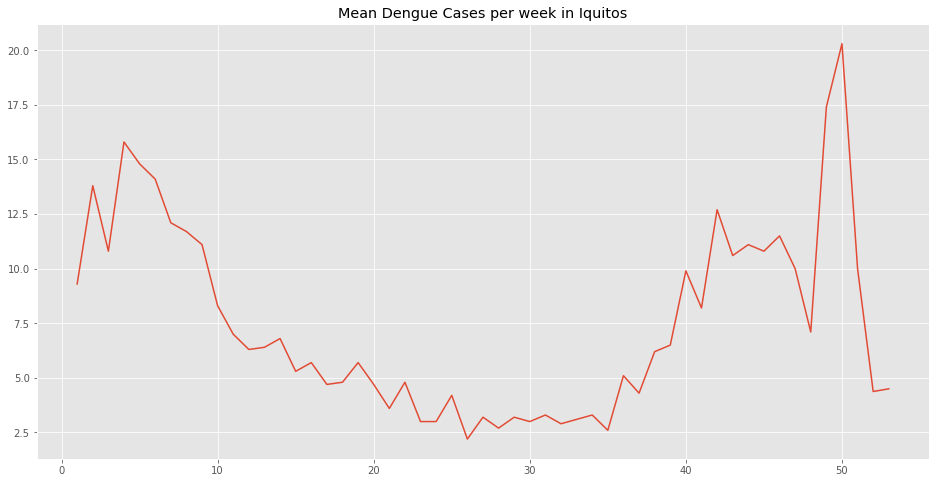

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(mean_iq_cases_week.index.values, mean_iq_cases_week.total_cases.values, ax=ax)
plt.title('Mean Dengue Cases per week in Iquitos')

# Cases vs Time Conclusion

It is visible how total cases spikes have decreased as time kept going (which could be due to medical advancements). It is also visible that San Juan and Iquitos both have different spiking seasons. This must be true as they are at different locations.
\
\
Here it is easier to see that in San Juan the cases start going up in July, and the highest peak of dengue infections is in september. Approaching the summer (April) tends to be where the least cases are diagnosed. The peak season makes sense, since Puerto Rico is located in the atlantic and hurricane season starts at the end of July and peaks in September.

![](https://upload.wikimedia.org/wikipedia/commons/8/82/1851-2017_Atlantic_hurricanes_and_tropical_storms_by_month.png)

For Iquitos there isnt as much data for me to give an accurate estimate on which seasons get the most dengue cases. But according to the mean lineplot, the peak tends to be in December.

# PCA

Text(0.5, 0, 'Principal Components')

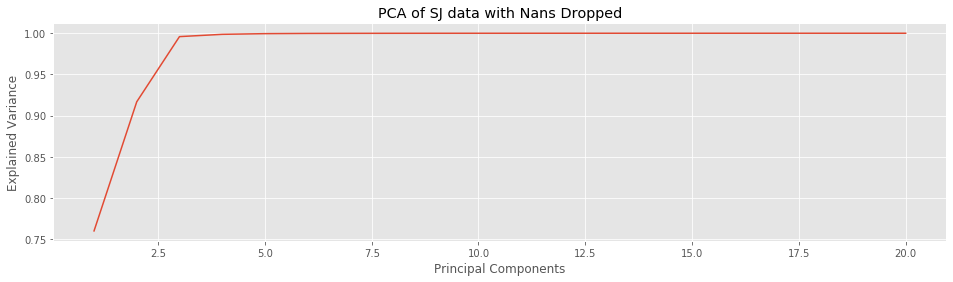

In [35]:
#verifying the principal components by only using numeric columns
pca_sj = PCA()

sj_train_NA_dropped = train_concat[train_concat['city']=='sj'].dropna().reset_index()
pca_sj.fit(sj_train_NA_dropped[numeric_cols])
fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(np.arange(1,21),np.cumsum(pca_sj.explained_variance_ratio_), ax=ax)
plt.title('PCA of SJ data with Nans Dropped')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')

The SJ data can be reduced from 20 dimensions to 3 dimensions (3 Principal Componens)

In [36]:
#transforming the SJ data into a 3PC data
pca_sj = PCA(n_components=3)
sj_pca_df=pd.DataFrame(data = pca_sj.fit_transform(sj_train_NA_dropped[numeric_cols]),
                      columns = ['PC1','PC2','PC3'])

#unifying the PCA data with its target

sj_pca_df = pd.concat([sj_pca_df, sj_train_NA_dropped[['total_cases']]], axis=1)

sj_pca_df

PC1        PC2        PC3  total_cases
0   -32.598704  11.761661   4.595266            4
1   -25.211707  -7.627781  10.446693            5
2     0.735697  -0.047360 -15.970429            4
3   -37.145732  -8.184074  12.046212            3
4   -47.368622  -5.364465   8.105726            6
..         ...        ...        ...          ...
722 -62.345152 -13.040085   8.452302            3
723 -24.667279 -20.727718  15.255952            4
724 -56.425532 -12.409954  10.057602            3
725 -22.119143  14.924026  -7.578541            1
726 -61.796428 -11.756210   8.980104            5

[727 rows x 4 columns]

In [37]:
np.sum(pca_sj.explained_variance_ratio_)

0.995905180421873

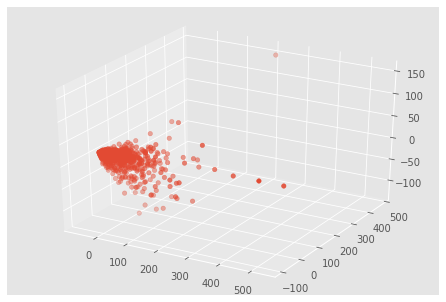

In [38]:
fig = plt.figure()
ax=Axes3D(fig)

ax.scatter(xs=sj_pca_df.PC1,ys=sj_pca_df.PC2,zs=sj_pca_df.PC3, zdir='z', label='ys=0, zdir=z')
plt.show()

Text(0.5, 0, 'Principal Components')

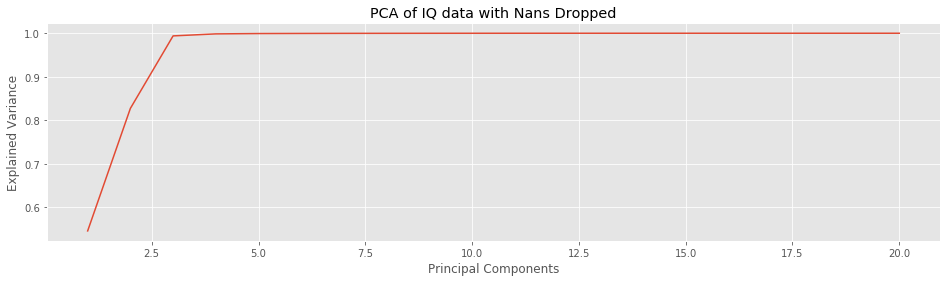

In [39]:
pca_iq = PCA()

iq_train_NA_dropped = train_concat[train_concat['city']=='iq'].dropna().reset_index()

pca_iq.fit(iq_train_NA_dropped[numeric_cols].dropna())

fig, ax = plt.subplots(figsize=(16,4))

sns.lineplot(np.arange(1,21),np.cumsum(pca_iq.explained_variance_ratio_), ax=ax)
plt.title('PCA of IQ data with Nans Dropped')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')

Same as before, this can be simplified into 3 Principal Components

In [40]:
#transforming the iq data into a 3PC data
pca_iq = PCA(n_components=3)
iq_pca_df=pd.DataFrame(data = pca_iq.fit_transform(iq_train_NA_dropped[numeric_cols]),
                      columns = ['PC1','PC2','PC3'])

#unifying the PCA data with its target

iq_pca_df = pd.concat([iq_pca_df, iq_train_NA_dropped[['total_cases']]], axis=1)

iq_pca_df

PC1         PC2        PC3  total_cases
0   -81.502305    0.862298  21.768124            0
1   -13.993999   -8.366757  -2.847845            0
2   -25.418833   13.713509   7.054821            0
3   -79.277748  -36.899444  43.625974            0
4   -59.561240    6.366726 -27.188050            0
..         ...         ...        ...          ...
467 -41.450012    2.645747  -5.488975            5
468  40.097663  142.733388  38.388293            8
469 -52.853490   18.823972 -12.642852            1
470 -41.533165   24.375337  -5.394686            1
471 -44.143961    2.619340 -20.539404            4

[472 rows x 4 columns]

In [41]:
np.sum(pca_iq.explained_variance_ratio_)

0.993907586229688

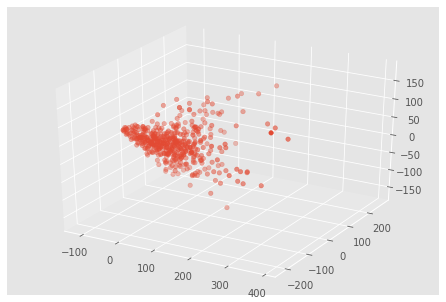

In [42]:
fig = plt.figure()
ax=Axes3D(fig)

ax.scatter(xs=iq_pca_df.PC1,ys=iq_pca_df.PC2,zs=iq_pca_df.PC3, zdir='z', label='ys=0, zdir=z')
plt.show()

# PCA Conclusion

As seen, both datasets can be expressed into 3 Principal Components which contain 99% of the data's. This is perfect as we do not lose variance and can indeed simplify the machine learning process as well as our data.
\
\
StandardScaler was not used as it tended to not reduce the dimensions, but increase them. Thus, it is better to work with the PCA without a Scaler.

# Creating training/testing Datasets

In [43]:
#Creating train/test for SJ

sj_train_data_dates = date_all_train_data[date_all_train_data['city'] == 'sj']
mask_sj = np.random.rand(len(sj_train_data_dates)) < 0.8
sj_train_ML = sj_train_data_dates[mask_sj].copy()
sj_test_ML = sj_train_data_dates[~mask_sj].copy()

y_sj_train = sj_train_ML[['total_cases']]
X_sj_train = sj_train_ML[numeric_cols]

y_sj_test = sj_test_ML[['total_cases']]
X_sj_test = sj_test_ML[numeric_cols]

#Creating Train/test for IQ
iq_train_data_dates = date_all_train_data[date_all_train_data['city'] == 'iq']
mask_iq = np.random.rand(len(iq_train_data_dates)) <0.8
iq_train_ML = iq_train_data_dates[mask_iq].copy()
iq_test_ML = iq_train_data_dates[~mask_iq].copy()

y_iq_train = iq_train_ML[['total_cases']]
X_iq_train = iq_train_ML[numeric_cols]

y_iq_test = iq_test_ML[['total_cases']]
X_iq_test = iq_test_ML[numeric_cols]

In [44]:
#functions for plotting training predictions
def train_plotter(name, prediction, city):
    fig, ax = plt.subplots(figsize=(18,8))
    
    if(city == 'sj'):
        sns.lineplot(X_sj_train.index, y_sj_train.values[:,0], color = 'red', label='Real', ax=ax)
        sns.lineplot(X_sj_train.index.values, prediction, color = 'blue', ax=ax, label = 'Fit')
        
    elif(city == 'iq'):
        sns.lineplot(X_iq_train.index, y_iq_train.values[:,0], color = 'red', label='Real', ax=ax)
        sns.lineplot(X_iq_train.index.values, prediction, color = 'blue', ax=ax, label = 'Fit')

    plt.legend()
    plt.title(name)
    plt.show()                
    
def test_plotter(name, prediction, city):
    fig, ax = plt.subplots(figsize=(18,8))
    
    if(city == 'sj'):
        sns.lineplot(X_sj_test.index, y_sj_test.values[:,0], color = 'red', label='Real', ax=ax)
        sns.lineplot(X_sj_test.index.values, prediction, color = 'blue', ax=ax, label = 'Fit')
    
    elif(city=='iq'):
        fig, ax = plt.subplots(figsize=(18,8))
        sns.lineplot(X_iq_test.index, y_iq_test.values[:,0], color = 'red', label='Real', ax=ax)
        sns.lineplot(X_iq_test.index.values, prediction, color = 'blue', ax=ax, label = 'Fit')
        
    plt.legend()
    plt.title(name)
    plt.show()

# Benchtesting best ML Model

## Linear Regression SJ

In [45]:
LinearRegression = LinearRegression(n_jobs=12)
LinearRegression.fit(X_sj_train,y_sj_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=12, normalize=False)

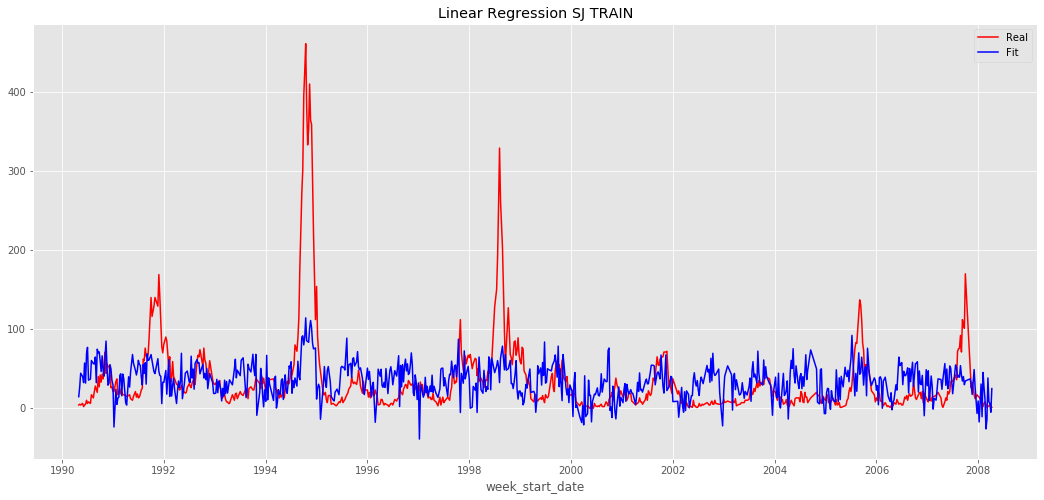

In [46]:
train_plotter('Linear Regression SJ TRAIN', LinearRegression.predict(X_sj_train)[:,0], 'sj')

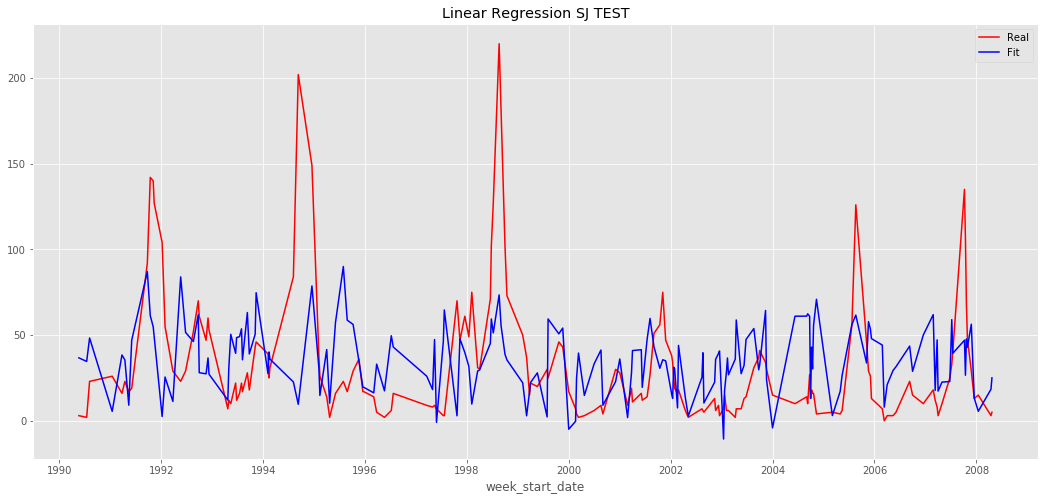

In [47]:
test_plotter('Linear Regression SJ TEST', LinearRegression.predict(X_sj_test)[:,0], 'sj')

## Poisson Regression SJ

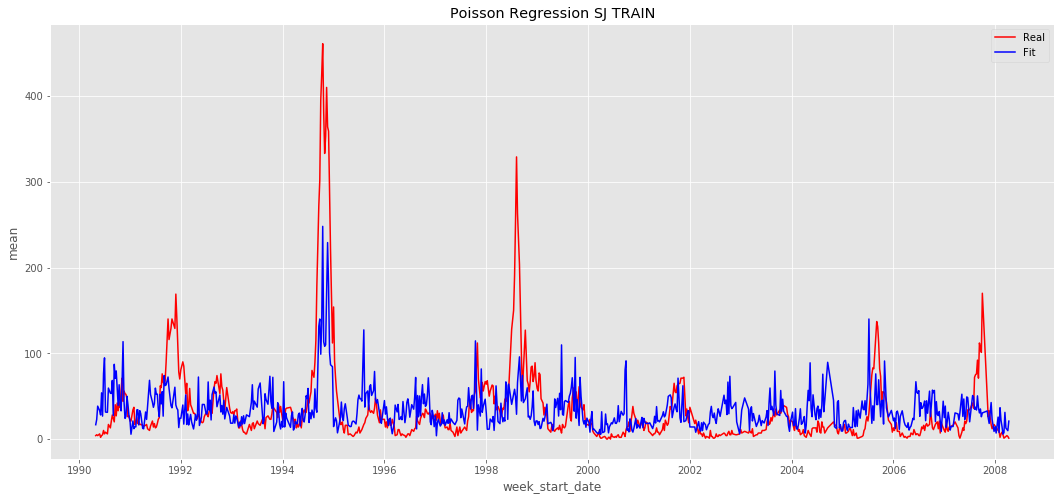

In [48]:
sj_poisson_training_result = sm.GLM(y_sj_train, X_sj_train,family = sm.families.Poisson()).fit()

train_plotter('Poisson Regression SJ TRAIN', sj_poisson_training_result.get_prediction(X_sj_train).summary_frame()['mean'], 'sj')

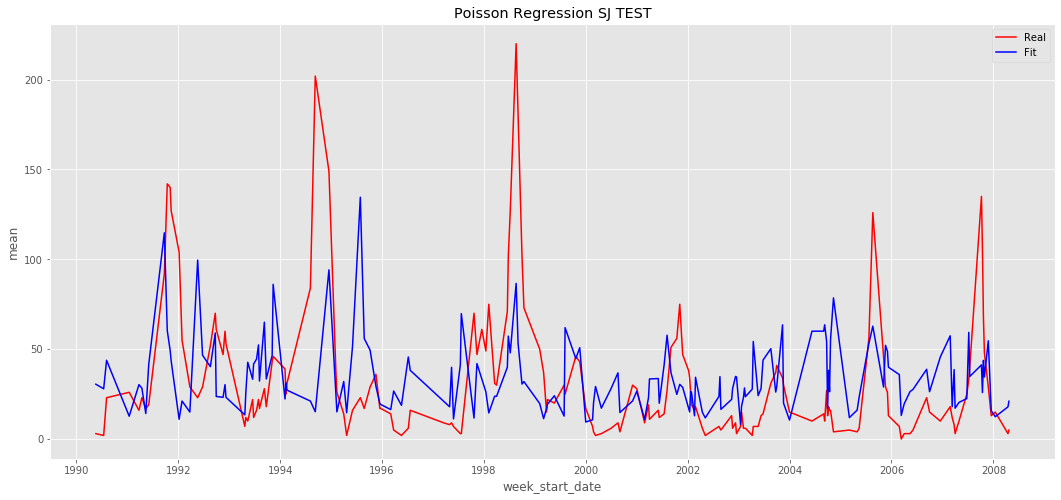

In [49]:
test_plotter('Poisson Regression SJ TEST', sj_poisson_training_result.get_prediction(X_sj_test).summary_frame()['mean'], 'sj')

## Suport Vector Regression

In [50]:
svr = SVR(kernel = 'linear', C = 0.01, degree = 1, epsilon = 1)

svr.fit(X_sj_train, y_sj_train)

C:\Users\HGSM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=0.01, cache_size=200, coef0=0.0, degree=1, epsilon=1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

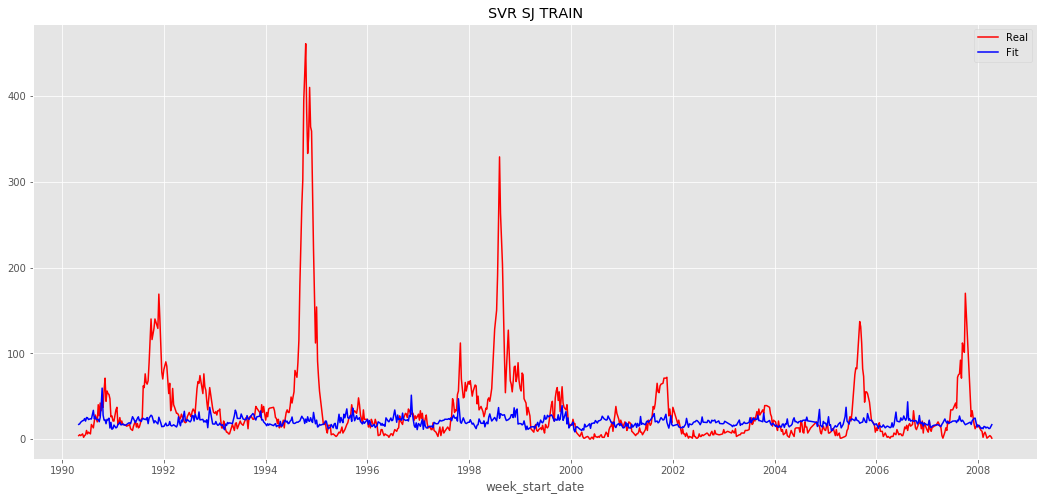

In [51]:
train_plotter('SVR SJ TRAIN', svr.predict(X_sj_train), 'sj')

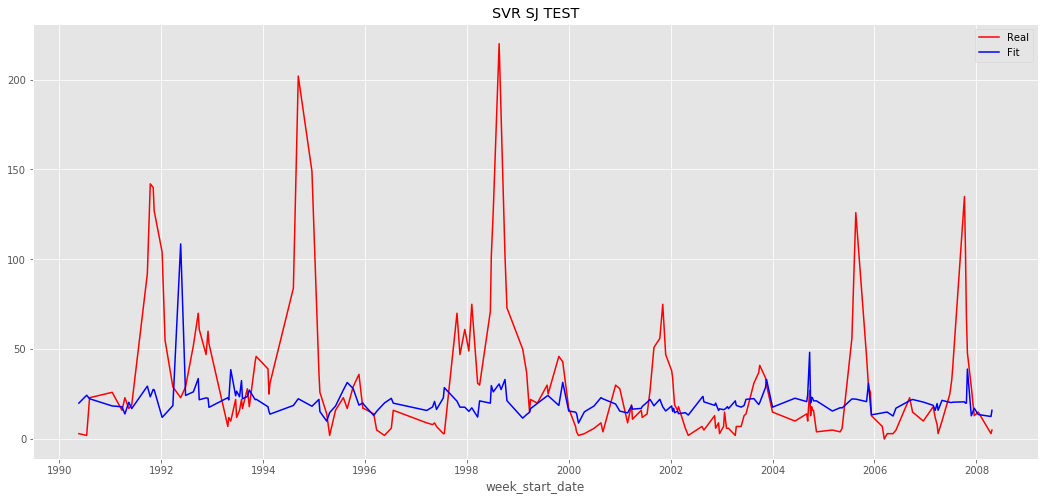

In [52]:
test_plotter('SVR SJ TEST', svr.predict(X_sj_test), 'sj')

## Random Forest Regressor SJ

In [53]:
RFR = RandomForestRegressor(n_estimators = 1000)
RFR.fit(X_sj_train, y_sj_train)

C:\Users\HGSM\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

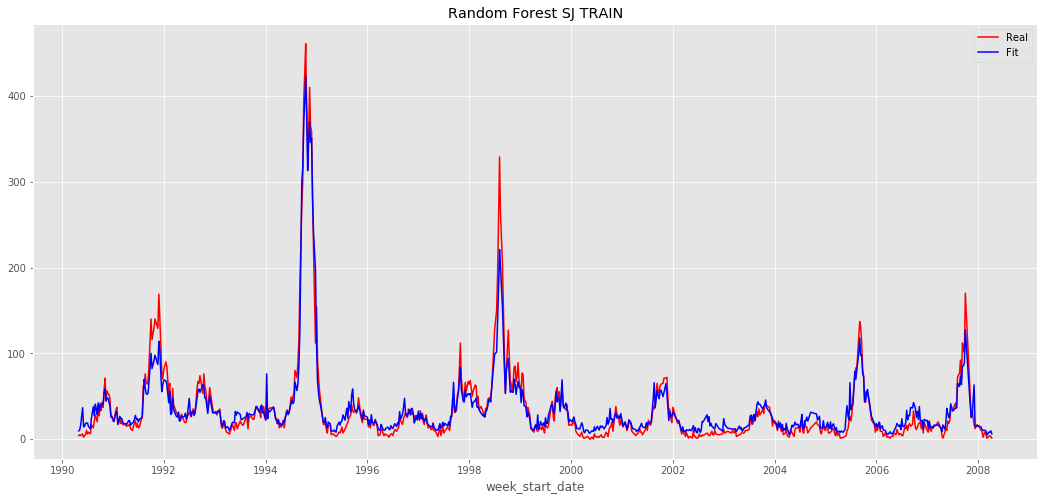

In [54]:
train_plotter('Random Forest SJ TRAIN', RFR.predict(X_sj_train), 'sj')

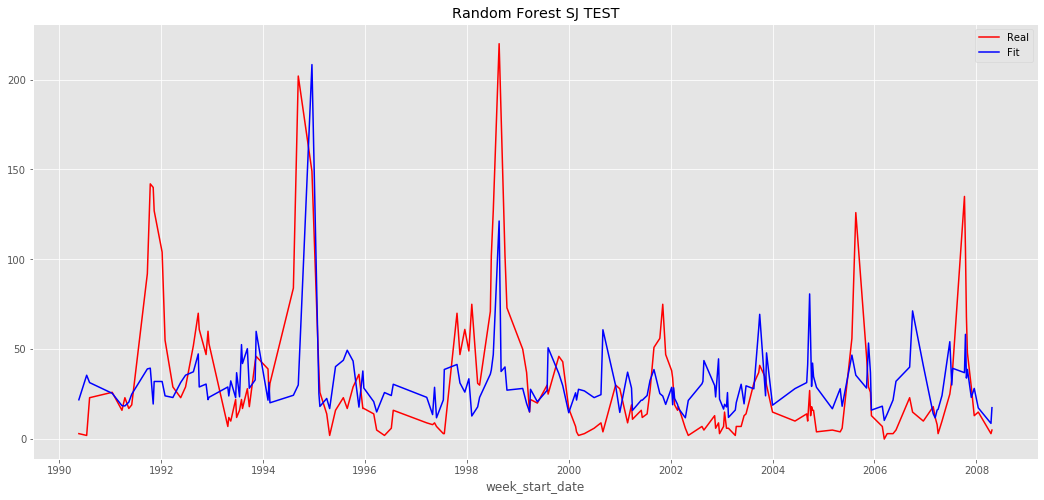

In [55]:
test_plotter('Random Forest SJ TEST', RFR.predict(X_sj_test), 'sj')

## Gradient Booster SJ

In [56]:
GBR = GradientBoostingRegressor(n_estimators = 1000, max_depth = 10, max_features = 4)
GBR.fit(X_sj_train, y_sj_train)

C:\Users\HGSM\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=4, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

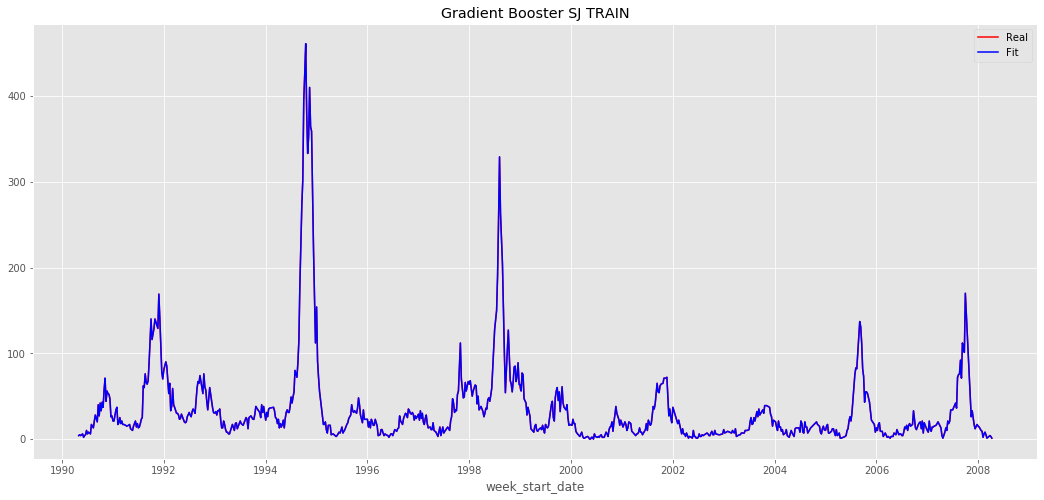

In [57]:
train_plotter('Gradient Booster SJ TRAIN', GBR.predict(X_sj_train), 'sj')

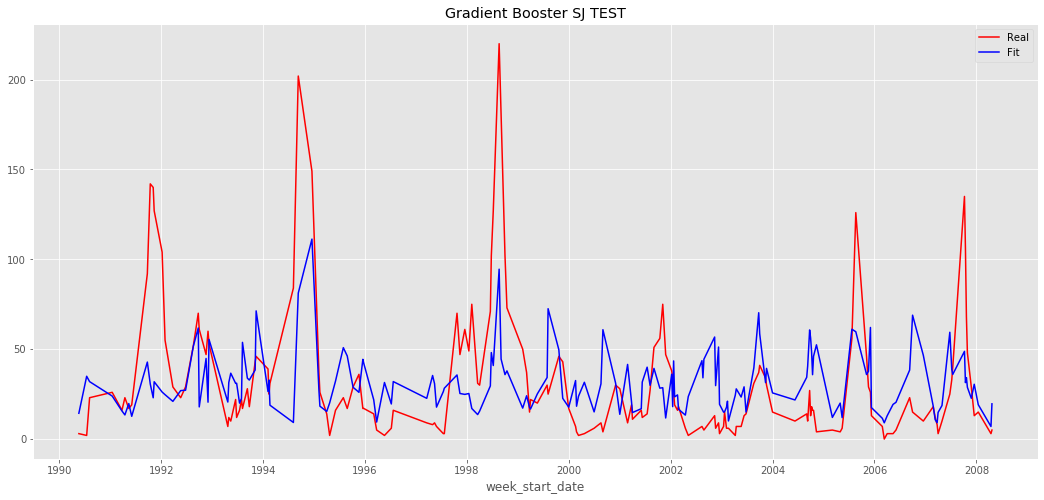

In [58]:
test_plotter('Gradient Booster SJ TEST', GBR.predict(X_sj_test), 'sj')

## Ada Boost Regressor SJ

In [59]:
ABR = AdaBoostRegressor(n_estimators = 1000)
ABR.fit(X_sj_train, y_sj_train)

C:\Users\HGSM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=1000, random_state=None)

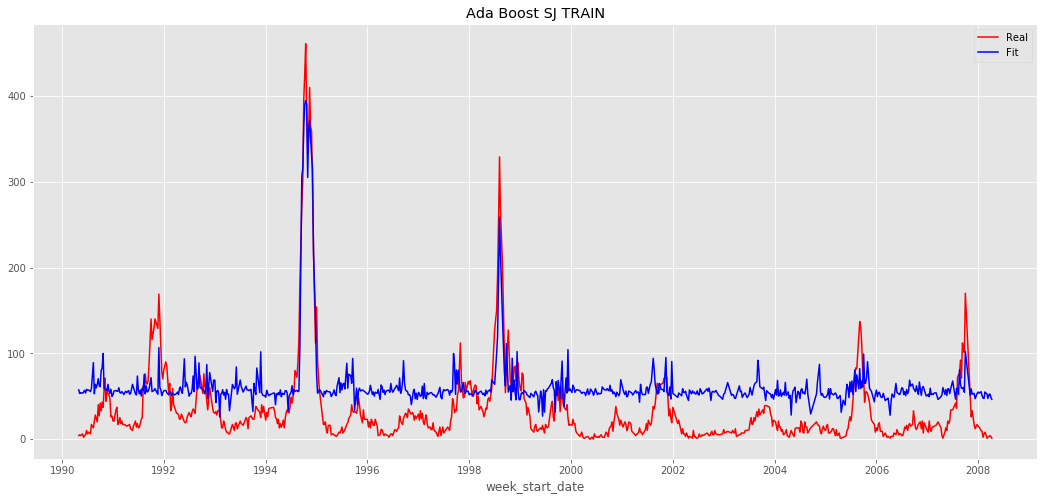

In [60]:
train_plotter('Ada Boost SJ TRAIN', ABR.predict(X_sj_train), 'sj')

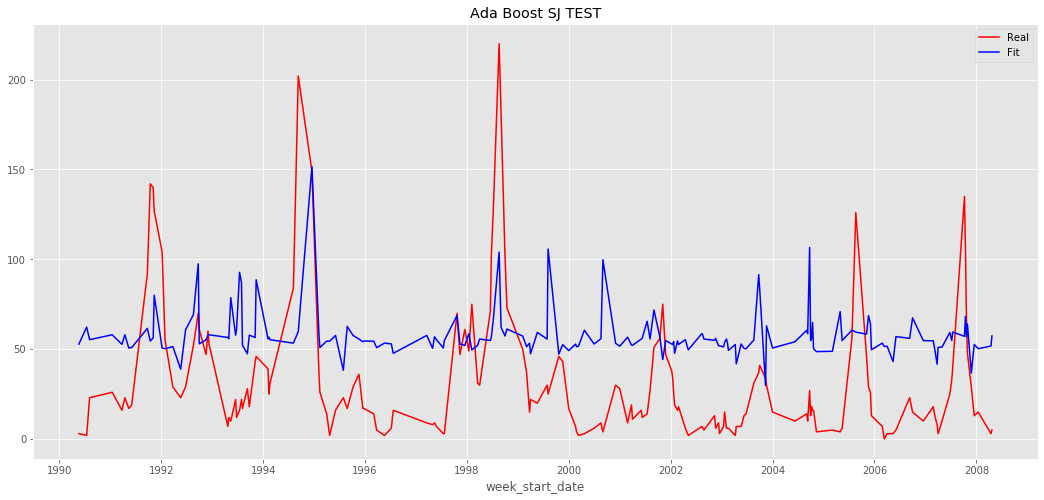

In [61]:
test_plotter('Ada Boost SJ TEST', ABR.predict(X_sj_test), 'sj')

# Keras Regression

In [62]:
model=Sequential()
model.add(Dense(100, input_shape=(20,)))
model.add(Dropout(0.4))
model.add(Dense(50))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

H = model.fit(X_sj_train, y_sj_train)

Epoch 1/1
755/755 [==============================] - 0s 193us/step - loss: 120.8098


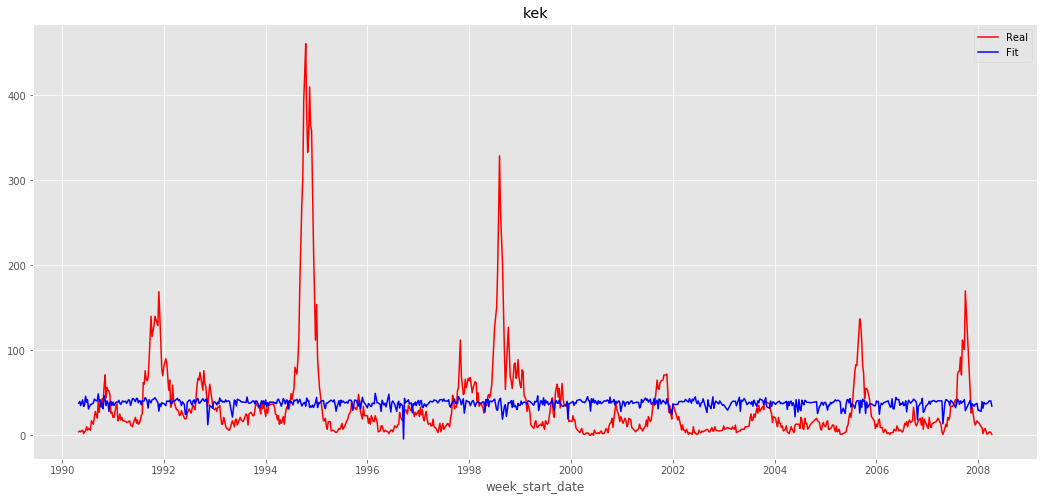

In [63]:
train_plotter('kek',model.predict(X_sj_train)[:,0], 'sj')

# Conclusion for best ML Model

I decided to not waste time with IQ data in this section as there is more data for SJ and this was only a test of which model could perform best on the given data.
\
\
Out of all the above, Random Forest Regressor and Gradient Booster both performed the best. The linear regression, as expected, did not work very well. The poisson is an okay model, but its still missing on alot of gaps. The negative binomial was removed as it did not present any changes in comparison to the poisson model. I had expected the support vector regression to perform the best, but as seen it is almos the worst of them all.
\
\
In the end I attempted to create a Keras deep learning for regression, but it was not very good. I don't feel experienced enough at the moment to create a good network for it, but in the future I might improve on it.

With both Random Forest and Gradient Booster being the best, I can now improve these models and make a better prediction on what the future cases could be for both SJ and IQ data.

# Using Random Forest for Prediction

In [64]:
all_data_date = all_data.set_index(all_data.week_start_date)
future_test_sj = all_data_date[(all_data_date['city']=='sj') & (all_data_date['set_type']=='test')].fillna(method='ffill')

In [65]:
RFR2 = RandomForestRegressor(n_estimators = 1000)

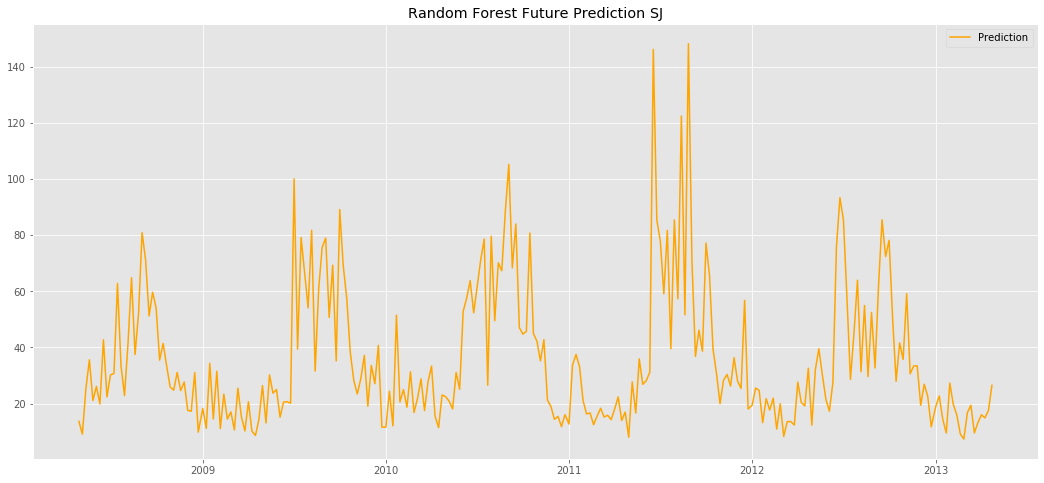

In [66]:
RFR2.fit(sj_train_data_dates[numeric_cols], sj_train_data_dates['total_cases'])

sj_future_preds = RFR2.predict(future_test_sj[numeric_cols])

fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(future_test_sj.index.values, sj_future_preds, color = 'orange', ax=ax, label = 'Prediction')
plt.legend()
plt.title('Random Forest Future Prediction SJ')
plt.show()

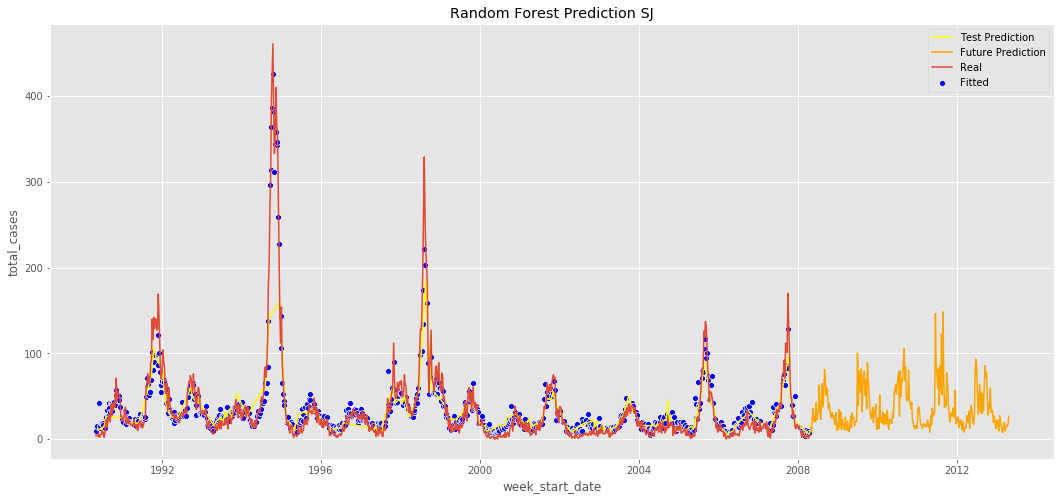

In [67]:
fig, ax = plt.subplots(figsize=(18,8))
sns.scatterplot(X_sj_train.index.values, RFR2.predict(X_sj_train), color = 'blue', ax=ax, label = 'Fitted')
sns.lineplot(X_sj_test.index.values, RFR2.predict(X_sj_test),dashes=[(2,2),(2,2)], color = 'yellow', ax=ax, label = 'Test Prediction')
sns.lineplot(future_test_sj.index.values, sj_future_preds, color = 'orange', ax=ax, label = 'Future Prediction')
sns.lineplot('week_start_date','total_cases',data=all_train_data[all_train_data['city']=='sj'], ax=ax, label = 'Real')
plt.legend()
plt.title('Random Forest Prediction SJ')
plt.show() 

In [68]:
sj_submission = pd.DataFrame(sj_future_preds.astype(int), columns = ['total_cases'], index=future_test_sj.index)
sj_submission['year']=future_test_sj['year']
sj_submission['city']='sj'
sj_submission['weekofyear'] = future_test_sj['weekofyear']
sj_submission

total_cases  year city  weekofyear
week_start_date                                    
2008-04-29                13  2008   sj          18
2008-05-06                 9  2008   sj          19
2008-05-13                25  2008   sj          20
2008-05-20                35  2008   sj          21
2008-05-27                21  2008   sj          22
...                      ...   ...  ...         ...
2013-03-26                13  2013   sj          13
2013-04-02                15  2013   sj          14
2013-04-09                14  2013   sj          15
2013-04-16                17  2013   sj          16
2013-04-23                26  2013   sj          17

[260 rows x 4 columns]

In [69]:
future_test_iq = all_data_date[(all_data_date['city']=='iq') & (all_data_date['set_type']=='test')].fillna(method='ffill')

In [70]:
RFR3 = RandomForestRegressor(n_estimators = 1000)

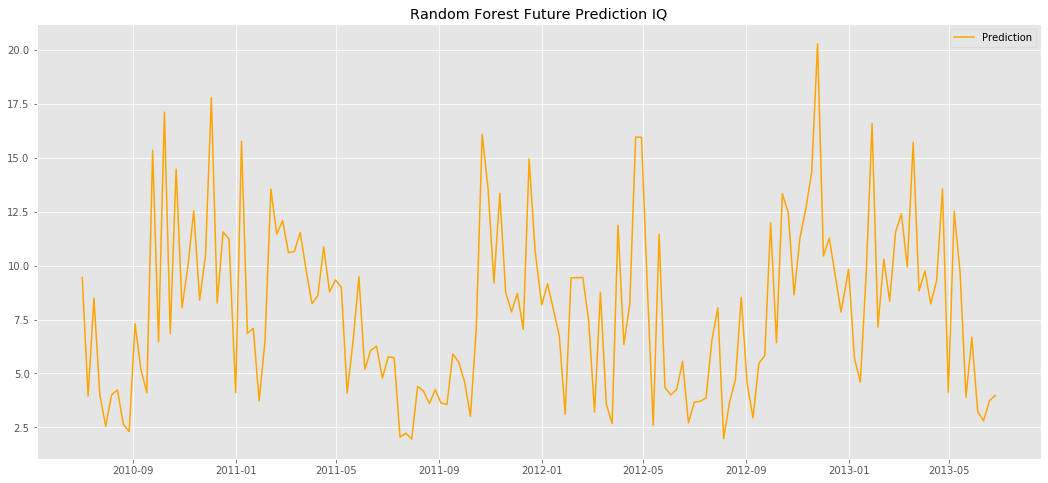

In [71]:
RFR3.fit(iq_train_data_dates[numeric_cols], iq_train_data_dates['total_cases'])

iq_future_preds = RFR3.predict(future_test_iq[numeric_cols])

fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(future_test_iq.index.values, iq_future_preds, color = 'orange', ax=ax, label = 'Prediction')
plt.legend()
plt.title('Random Forest Future Prediction IQ')
plt.show()

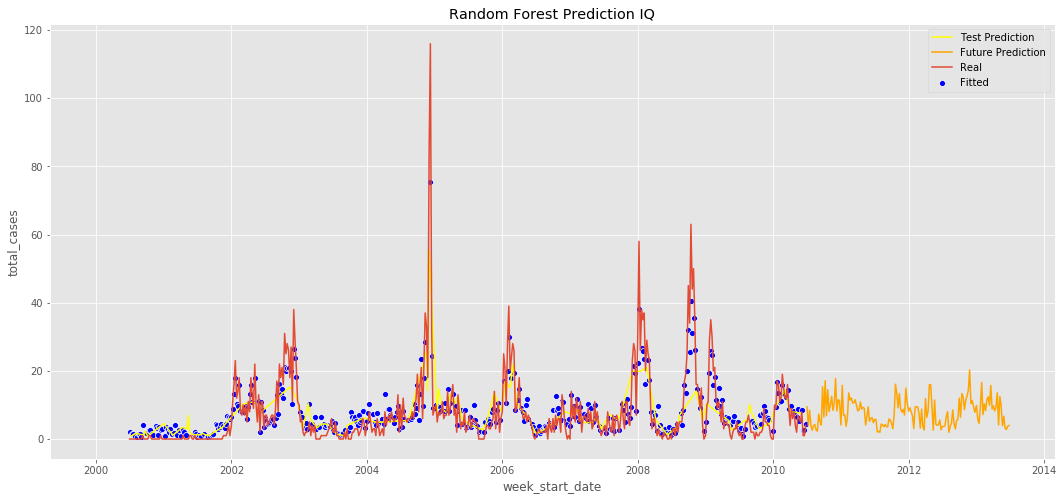

In [72]:
fig, ax = plt.subplots(figsize=(18,8))
sns.scatterplot(X_iq_train.index.values, RFR3.predict(X_iq_train), color = 'blue', ax=ax, label = 'Fitted')
sns.lineplot(X_iq_test.index.values, RFR3.predict(X_iq_test),dashes=[(2,2),(2,2)], color = 'yellow', ax=ax, label = 'Test Prediction')
sns.lineplot(future_test_iq.index.values, iq_future_preds, color = 'orange', ax=ax, label = 'Future Prediction')
sns.lineplot('week_start_date','total_cases',data=all_train_data[all_train_data['city']=='iq'], ax=ax, label = 'Real')
plt.legend()
plt.title('Random Forest Prediction IQ')
plt.show() 

In [73]:
iq_submission = pd.DataFrame(iq_future_preds.astype(int), columns = ['total_cases'],index=future_test_iq.index)
iq_submission['year']=future_test_iq.year
iq_submission['weekofyear']=future_test_iq.weekofyear
iq_submission['city']='iq'
iq_submission

total_cases  year  weekofyear city
week_start_date                                    
2010-07-02                 9  2010          26   iq
2010-07-09                 3  2010          27   iq
2010-07-16                 8  2010          28   iq
2010-07-23                 4  2010          29   iq
2010-07-30                 2  2010          30   iq
...                      ...   ...         ...  ...
2013-05-28                 6  2013          22   iq
2013-06-04                 3  2013          23   iq
2013-06-11                 2  2013          24   iq
2013-06-18                 3  2013          25   iq
2013-06-25                 3  2013          26   iq

[156 rows x 4 columns]

In [74]:
all_submission = sj_submission.append(iq_submission)[['city','year','weekofyear','total_cases']]
all_submission = all_submission.reset_index()
all_submission.drop('week_start_date', axis=1, inplace=True)
all_submission

C:\Users\HGSM\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


city  year  weekofyear  total_cases
0     sj  2008          18           13
1     sj  2008          19            9
2     sj  2008          20           25
3     sj  2008          21           35
4     sj  2008          22           21
..   ...   ...         ...          ...
411   iq  2013          22            6
412   iq  2013          23            3
413   iq  2013          24            2
414   iq  2013          25            3
415   iq  2013          26            3

[416 rows x 4 columns]

In [75]:
all_submission.to_csv('pred_submission.csv', index=False)

# Prediction Conclusion

![](Score_28.jpg)
\
\
I a score of 28. Not bad, yet not as good as their provided benchmark of score 25. Nontheless, I learned alot from this project and have some ideas of how to improve it in the future, when I up my skill, to obtain a better score.
\
\
Initially I had obtained a score of 29 with Gradient Booster. After switching to Random Forest I was able to lower it to 28.
\
\
One of the first things I could do to improve is to find a way of replacing the unknown data for the test data (future prediction) as I simply forward filled it. Probably adding an imputer could help. Another thing is to discard or merge some of the features data since some are repeated. I can probably work out something with the PCA or the StandardScaler to make the model perform better.